In [2]:
import cv2
import numpy as np
import cv2
from numba import jit
from scipy.spatial import distance as dist
from warnings import warn
from types import BooleanType, IntType, StringType, FloatType, NoneType, TupleType
from ethomap.processing import VideoReader, VideoWriter
import matplotlib.pyplot as plt
from pinpoint import TagDictionary
from sklearn.metrics.pairwise import pairwise_distances

Using TensorFlow backend.


In [3]:
"""
Copyright 2015-2017 Jacob M. Graving <jgraving@gmail.com>

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import numpy as np
import cv2
from numba import jit
from scipy.spatial import distance as dist
from warnings import warn
from types import BooleanType, IntType, StringType, FloatType, NoneType, TupleType

def rotate_tag90(tag, tag_shape, n=1):
	
	"""Rotate barcode tag 90 degrees.
		
		Parameters
		----------
		tag : 1-D array_like
			Flattened barcode tag.
		tag_shape : tuple of int
			Shape of the barcode tag.
		n : int
			Number of times to rotate 90 degrees.
		
		
		Returns
		-------
		tag_rot : 1-D array
			Returns rotated tag flattened to 1-D array.
		
		"""
	
	tag = np.asarray(tag)
	vector_shape = tag.shape
	tag = tag.reshape(tag_shape)
	tag_rot = np.rot90(tag,n)
	tag_rot = tag_rot.reshape(vector_shape)
	return tag_rot

def add_border(tag, tag_shape, white_width = 1, black_width = 1):
	
	"""Add black and white border to barcode tag.
		
		Parameters
		----------
		tag : 1-D array_like
			Flattened barcode tag.
		tag_shape : tuple of int
			Shape of the barcode tag without a border.
		white_width : int
			Width of white border.
		black_width : int
			Width of black border.
			
		Returns
		-------
		bordered_tag : 1-D array
			Returns tag with border added flattened to 1-D array.
		"""
	
	tag = np.asarray(tag)
	tag = tag.reshape(tag_shape)

	black_border = np.zeros((tag_shape[0]+(2*white_width)+(2*black_width),tag_shape[1]+(2*white_width)+(2*black_width)))
	white_border = np.ones((tag_shape[0]+(2*white_width),tag_shape[1]+(2*white_width)))
	
	white_border[white_width:tag_shape[0]+white_width,white_width:tag_shape[1]+white_width] = tag
	black_border[black_width:tag_shape[0]+(2*white_width)+black_width, black_width:tag_shape[1]+(2*white_width)+black_width] = white_border

	tag = black_border
	bordered_tag = tag.reshape((tag.shape[0]*tag.shape[1]))
	tag_shape = black_border.shape
	return  bordered_tag

def check_diffs(array1, array2, ndiffs, test_num):
	
	""" Check for differences between two arrays. Each element of array1 is checked against all elements of array2.
		
		Parameters
		----------
		array1 : 2-D array_like
			Array of flattened barcodes to test against array2.
		array2 : 2-D array_like
			Array of flattened barcodes to test array1 against.
		ndiffs : int
			Minimum number of differences between all barcodes in array1 and array2.
		test_num : int
			Number of elements in array2 that each element in array1 must be at least ndiffs different from.
			
		Returns
		-------
		test : int
			Number of elements in array1 that are at least ndiffs different from all elements in array2.
		
		"""
	
	array1 = np.asarray(array1).astype(np.uint8)
	array2 = np.asarray(array2).astype(np.uint8)
	test_list = np.array([], dtype = bool)
	
	for tag in array1:
		tag = np.asarray([tag]).astype(np.uint8)
		repeat_tags = np.repeat(tag, array2.shape[0], axis = 0)
		tag_diffs = np.subtract(array2,repeat_tags)
		tag_diffs[tag_diffs>1] = 1
		tag_diffs = np.sum(tag_diffs, axis = 1)
		diff_bool = tag_diffs >= ndiffs # test for minimum number of differences
		test = np.sum(diff_bool)
			
		if test == test_num: # if element in array1 is different enough from all elements in array2...
			test_list = np.append(test_list, True)
	
	test = np.sum(test_list)
	
	return test

def crop(src, pt1, pt2):
	
	""" Returns a cropped version of src """
	
	cropped = src[pt1[1]:pt2[1], pt1[0]:pt2[0]]
	
	return cropped

@jit(nopython = True)
def _order_points(points):

	# Check for clockwise order with crossproduct
	dx1 = points[1,0] - points[0,0]
	dy1 = points[1,1] - points[0,1]
	dx2 = points[2,0] - points[0,0]
	dy2 = points[2,1] - points[0,1]
	cross_product = (dx1 * dy2) - (dy1 - dx2)

	if cross_product < 0.0: # if not clockwise, reorder middle points
		clockwise = points.copy()
		clockwise[1] = points[3]
		clockwise[3] = points[1]
	else:
		clockwise = points
		
	x_sorted = clockwise[np.argsort(clockwise[:, 0]), :] # sort by x-coords
	left = x_sorted[:2,:] # get left side coordinates
	left = left[np.argsort(left[:, 1]), :] # sort left coords by y-coords
	top_left = left[0] # get top left corner
	
	top_left_condition = (clockwise[:,0] == top_left[0]) & (clockwise[:,1] == top_left[1])
	top_left_index = np.where(top_left_condition)[0][0] #get original location for top left corner
	
	#reorder from the top left corner
	if top_left_index == 0:
		ordered = clockwise
	elif top_left_index == 1:
		ordered = clockwise.copy()
		ordered[0] = clockwise[1]
		ordered[1] = clockwise[2]
		ordered[2] = clockwise[3]
		ordered[3] = clockwise[0]
	elif top_left_index == 2:
		ordered = clockwise.copy()
		ordered[0] = clockwise[2]
		ordered[1] = clockwise[3]
		ordered[2] = clockwise[0]
		ordered[3] = clockwise[1]
	elif top_left_index == 3:
		ordered = clockwise.copy()
		ordered[0] = clockwise[3]
		ordered[1] = clockwise[0]
		ordered[2] = clockwise[1]
		ordered[3] = clockwise[2]

	return ordered
	
def order_points(points):

	""" Order 4x2 array in clockwise order from top-left corner.

		Parameters
		----------
		points : array_like
			4x2 array of points to order.
			
		Returns
		-------
		ordered : ndarray
			Points ordered clockwise from top-left corner.
		
		"""
	if type(points) != np.ndarray:
		raise TypeError("points must be numpy array")
	if points.ndim != 2:
		raise ValueError("points must be 2-D array")
	if points.shape != (4,2):
		raise ValueError("points must be 4x2 array")
	if points.dtype != np.dtype(np.float32):
		points = points.astype(np.float32)
		
	ordered = _order_points(points)
	
	return ordered

def angle(vector, degrees = True):
	
	"""Returns the angle between vectors 'v1' and 'v2'.
		
		Parameters
		----------
		v1 : 1-D array_like
			N-dimensional vector.
		v2 : 1-D array_like
			N-dimensional vector.
		degrees : bool, default = True
			Return angle in degrees.
			
		Returns
		-------
		angle : float
			Angle between v1 and v2.
		
		"""
	
	angle = np.arctan2(vector[1], vector[0]) % (2*np.pi)
	if np.isnan(angle):
		if (v1_u == v2_u).all():
			return 0.0
		else:
			return np.pi
	if degrees == True:
		angle = np.degrees(angle)
	return angle

def get_grayscale(color_image, channel = None):

	""" Returns single-channel grayscale image from 3-channel BGR color image.

		Parameters
		----------
		color_image : (MxNx3) numpy array
			3-channel BGR-format color image as a numpy array
		channel : {'blue', 'green', 'red', 'none', None}, default = None
			The color channel to use for producing the grayscale image.
			
		Returns
		-------
		gray_image : (MxNx1) numpy array
			Single-channel grayscale image as a numpy array.

		Notes
		----------
		For channel, None uses the default linear transformation from OpenCV: Y = 0.299R + 0.587G + 0.114B
		Channels 'blue', 'green', and 'red' use the respective color channel as the grayscale image. 
		Under white ambient lighting, 'green' typically provides the lowest noise. Under red and infrared lighting, 'red' typically provides the lowest noise.

	"""
	if type(channel) not in [StringType, NoneType]:
		raise TypeError("Channel must be type str or None")
	if type(channel) is StringType and not (channel.startswith('b') or channel.startswith('g') or channel.startswith('r')):
		raise ValueError("Channel value must be 'blue', 'green', 'red', or None")
	if type(color_image) is not np.ndarray:
		raise TypeError("image must be a numpy array")


	if len(color_image.shape) != 3:
		raise ValueError("image must be color (MxNx3)")
	if color_image.shape[2] != 3:
		raise ValueError("image must have 3 color channels (MxNx3)")
	if color_image.dtype is not np.dtype(np.uint8):
		raise TypeError("image array must be dtype np.uint8")

	if channel.startswith('b'):
		gray_image, _, _ = cv2.split(color_image)
	elif channel.startswith('g'):
			_, gray_image, _ = cv2.split(color_image)
	elif channel.startswith('r'):
		_, _, gray_image = cv2.split(color_image)
	elif channel is None:
		gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

	return gray_image

def get_threshold(gray_image, block_size = 1001, offset = 2):

	""" Returns binarized thresholded image from single-channel grayscale image.

		Parameters
		----------
		gray_image : (MxNx1) numpy array
			Single-channel grayscale image as a numpy array
		block_size : int, default = 1001
			Odd value integer. Size of the local neighborhood for adaptive thresholding.
		offset : default = 2
			Constant subtracted from the mean. Normally, it is positive but may be zero or negative as well. 
			The threshold value is the mean of the block_size x block_size neighborhood minus offset.

		Returns
		-------
		threshold_image : (MxNx1) numpy array
			Binarized (0, 255) image as a numpy array.

	"""

	if block_size % 2 != 1:
		raise ValueError("block_size must be an odd value (block_size % 2 == 1)")
	if type(offset) not in [IntType, FloatType]:
		raise TypeError("offset must be type int or float")
	if type(gray_image) is not np.ndarray:
		raise TypeError("image must be a numpy array")
	if gray_image.ndim != 2:
		raise ValueError("image must be grayscale")
	if gray_image.dtype is not np.dtype(np.uint8):
		raise TypeError("image array must be dtype np.uint8")

	threshold_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, offset)

	return threshold_image

def get_contours(threshold_image):

	""" Returns a list of contours from a binarized thresholded image.

		Parameters
		----------
		threshold_image : (MxNx1) numpy array
			Binarized threshold image as a numpy array

		Returns
		-------
		contours : list
			List of contours extracted from threshold_image.

	"""
	if len(set([0, 255]) - set(np.unique(threshold_image))) != 0:
		raise ValueError("image must be binarized to (0, 255)")

	_, contours, _ = cv2.findContours(threshold_image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

	return contours

def get_polygon(contour, tolerance):

	perimeter = cv2.arcLength(contour, True)
	polygon = cv2.approxPolyDP(contour, tolerance * perimeter, True)
	polygon_area = cv2.contourArea(polygon, True)

	return (polygon, polygon_area, perimeter)

def test_edge_proximity(contour, edge_proximity, x_proximity, y_proximity):

	contour_reshape = np.squeeze(contour)
	contour_x = contour_reshape[:,0]
	contour_y = contour_reshape[:,1]
	flat = contour.flatten()

	edge_zero = np.sum(flat <= edge_proximity)
	edge_x = np.sum(contour_x >= x_proximity)
	edge_y = np.sum(contour_y >= y_proximity)

	if edge_zero == 0 and edge_x == 0 and edge_y == 0:
		edge_proximity_test = False
	else:
		edge_proximity_test = True

	return edge_proximity_test

def get_pixels(image, points, dst, max_side, barcode_size):

	M = cv2.getPerspectiveTransform(points.reshape((4,1,2)).astype(np.float32), dst)
	pixels = cv2.warpPerspective(image, M, (max_side, max_side), flags = (cv2.INTER_LINEAR), borderValue = 255)

	return pixels

def get_points(polygon):

	polygon = np.squeeze(polygon)
	points = order_points(polygon)
	points = polygon

	return points

def test_area(area, area_min, area_max, area_sign):
	if np.sign(area) == area_sign and area_min <= np.abs(area) <= area_max:
		area_test = True
	else:
		area_test = False

	return area_test

def test_quad(polygon, polygon_area, area_min, area_max, area_sign):

	# if 4 vertices, sign is correct, value is within range, and polygon is convex...
	if (polygon.shape[0] == 4 
		and test_area(polygon_area, area_min, area_max, area_sign)
		and cv2.isContourConvex(polygon)):

		quad_test = True

	else:
		quad_test = False

	return quad_test

def get_area(contour):

	return cv2.contourArea(contour, True)

def test_geometry(contour, area_min, area_max, area_sign, edge_proximity, x_proximity, y_proximity, tolerance):
	
	geometry_test = False
	polygon = None

	if contour.shape[0] > 4:

		edge_proximity_test = test_edge_proximity(contour, edge_proximity, x_proximity, y_proximity)

		if edge_proximity_test == False:

			contour_area = get_area(contour) # calculate the signed area

			if test_area(contour_area, area_min, area_max, area_sign): # if the sign is correct and value is within range...
				
				(polygon, polygon_area, perimeter) = get_polygon(contour, tolerance)
				peri_area_ratio = perimeter/contour_area

				if 100 > np.abs(peri_area_ratio) > 0:  # if perimeter_area_ratio is reasonable value...

					geometry_test = test_quad(polygon, polygon_area, area_min, area_max, area_sign)

	return (geometry_test, polygon)


def get_candidate_barcodes(image, contours, barcode_size, area_min, area_max, area_sign, edge_proximity, x_proximity, y_proximity, tolerance, max_side, dst):

	FIRST = True
	points_array = None
	pixels_array = None
	points = None
	pixels = None

	if len(contours) > 0: # if contours are found
					
		for (idx,contour) in enumerate(contours): # iterate over the list of contours

			(geometry_test, polygon) = test_geometry(contour, area_min, area_max, area_sign, edge_proximity, x_proximity, y_proximity, tolerance)
			
			if geometry_test == True:
				points = get_points(polygon)
				pixels = get_pixels(image, points, dst, max_side, barcode_size).reshape((1,-1))

				if FIRST == True:
					points_array = points.reshape((1,4,2))
					pixels_array = pixels
					FIRST = False
				else:
					points_array = np.append(points_array, points.reshape((1,4,2)), axis = 0)
					pixels_array = np.append(pixels_array, pixels, axis = 0) 

	return (points_array, pixels_array)

def correlate_barcodes(pixels, master_list):

	return rowwise_corr(pixels, master_list)

def match_barcodes(points_array, pixels_array, master_list, IDs, IDs_index, correlation_thresh):

    master_correlation_matrix = 1-pairwise_distances(pixels_array/255., master_list, metric='correlation')#correlate_barcodes(pixels_array, master_list)
    correlation_index = np.where(master_correlation_matrix > correlation_thresh)
    
    correlations = master_correlation_matrix[correlation_index]
    best_IDs_index = correlation_index[1]
    best_IDs = IDs[best_IDs_index]
    
    points_array = points_array[correlation_index[0]]
    pixels_array = pixels_array[correlation_index[0]]
    
    for idx, (points, best_index, ID) in enumerate(zip(points_array, best_IDs_index, best_IDs)):
        
        rotation_test = best_index % 4
        
        tl, tr, br, bl = points
        
        corners = np.zeros((4,2))

        if rotation_test == 3:
            corners = points

        if rotation_test == 0:
            corners[0] = bl
            corners[1] = tl
            corners[2] = tr
            corners[3] = br

        if rotation_test == 1:
            corners[0] = br
            corners[1] = bl
            corners[2] = tl
            corners[3] = tr

        if rotation_test == 2:
            corners[0] = tr
            corners[1] = br
            corners[2] = bl
            corners[3] = tl
    
        points_array[idx] = corners
        
    return (points_array, best_IDs, correlations)

def get_warp_dst(max_side = 100):
	
	length = max_side - 1
	dst = np.array([[0, 0],
					[length, 0],
					[length, length],
					[0, length]],
					dtype = "float32")

	return dst




In [3]:
tags = TagDictionary()
tags.load_dict('/Users/jake/Google Drive/barcodes/robust_9bit_barcodes/master_list.pkl')

In [4]:
master_list = tags.master_list

In [5]:
master_list.shape

(152, 25)

In [6]:
bordered = []
for tag in master_list:
    new_tag = add_border(tag, (5,5), white_width=1, black_width=0)
    #new_tag = cv2.resize(new_tag.reshape((7,7)), (7,7)).flatten()
    bordered.append(new_tag)
master_list = np.array(bordered)

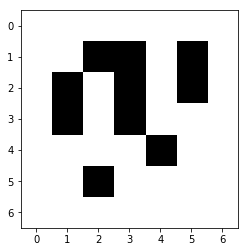

In [7]:
plt.imshow(master_list[35].reshape((7,7)), cmap='gray', interpolation='none')
plt.show()

In [8]:
IDs = tags.id_list

In [9]:
master_list.shape

(152, 49)

In [491]:
cap = VideoReader("/Volumes/Samsung T3/20161216_095355.nvenc-slow-yuv420-gray.mp4")
frames = cap.read_batch(100)
cap.close()

True

In [492]:
frame = frames[-1]

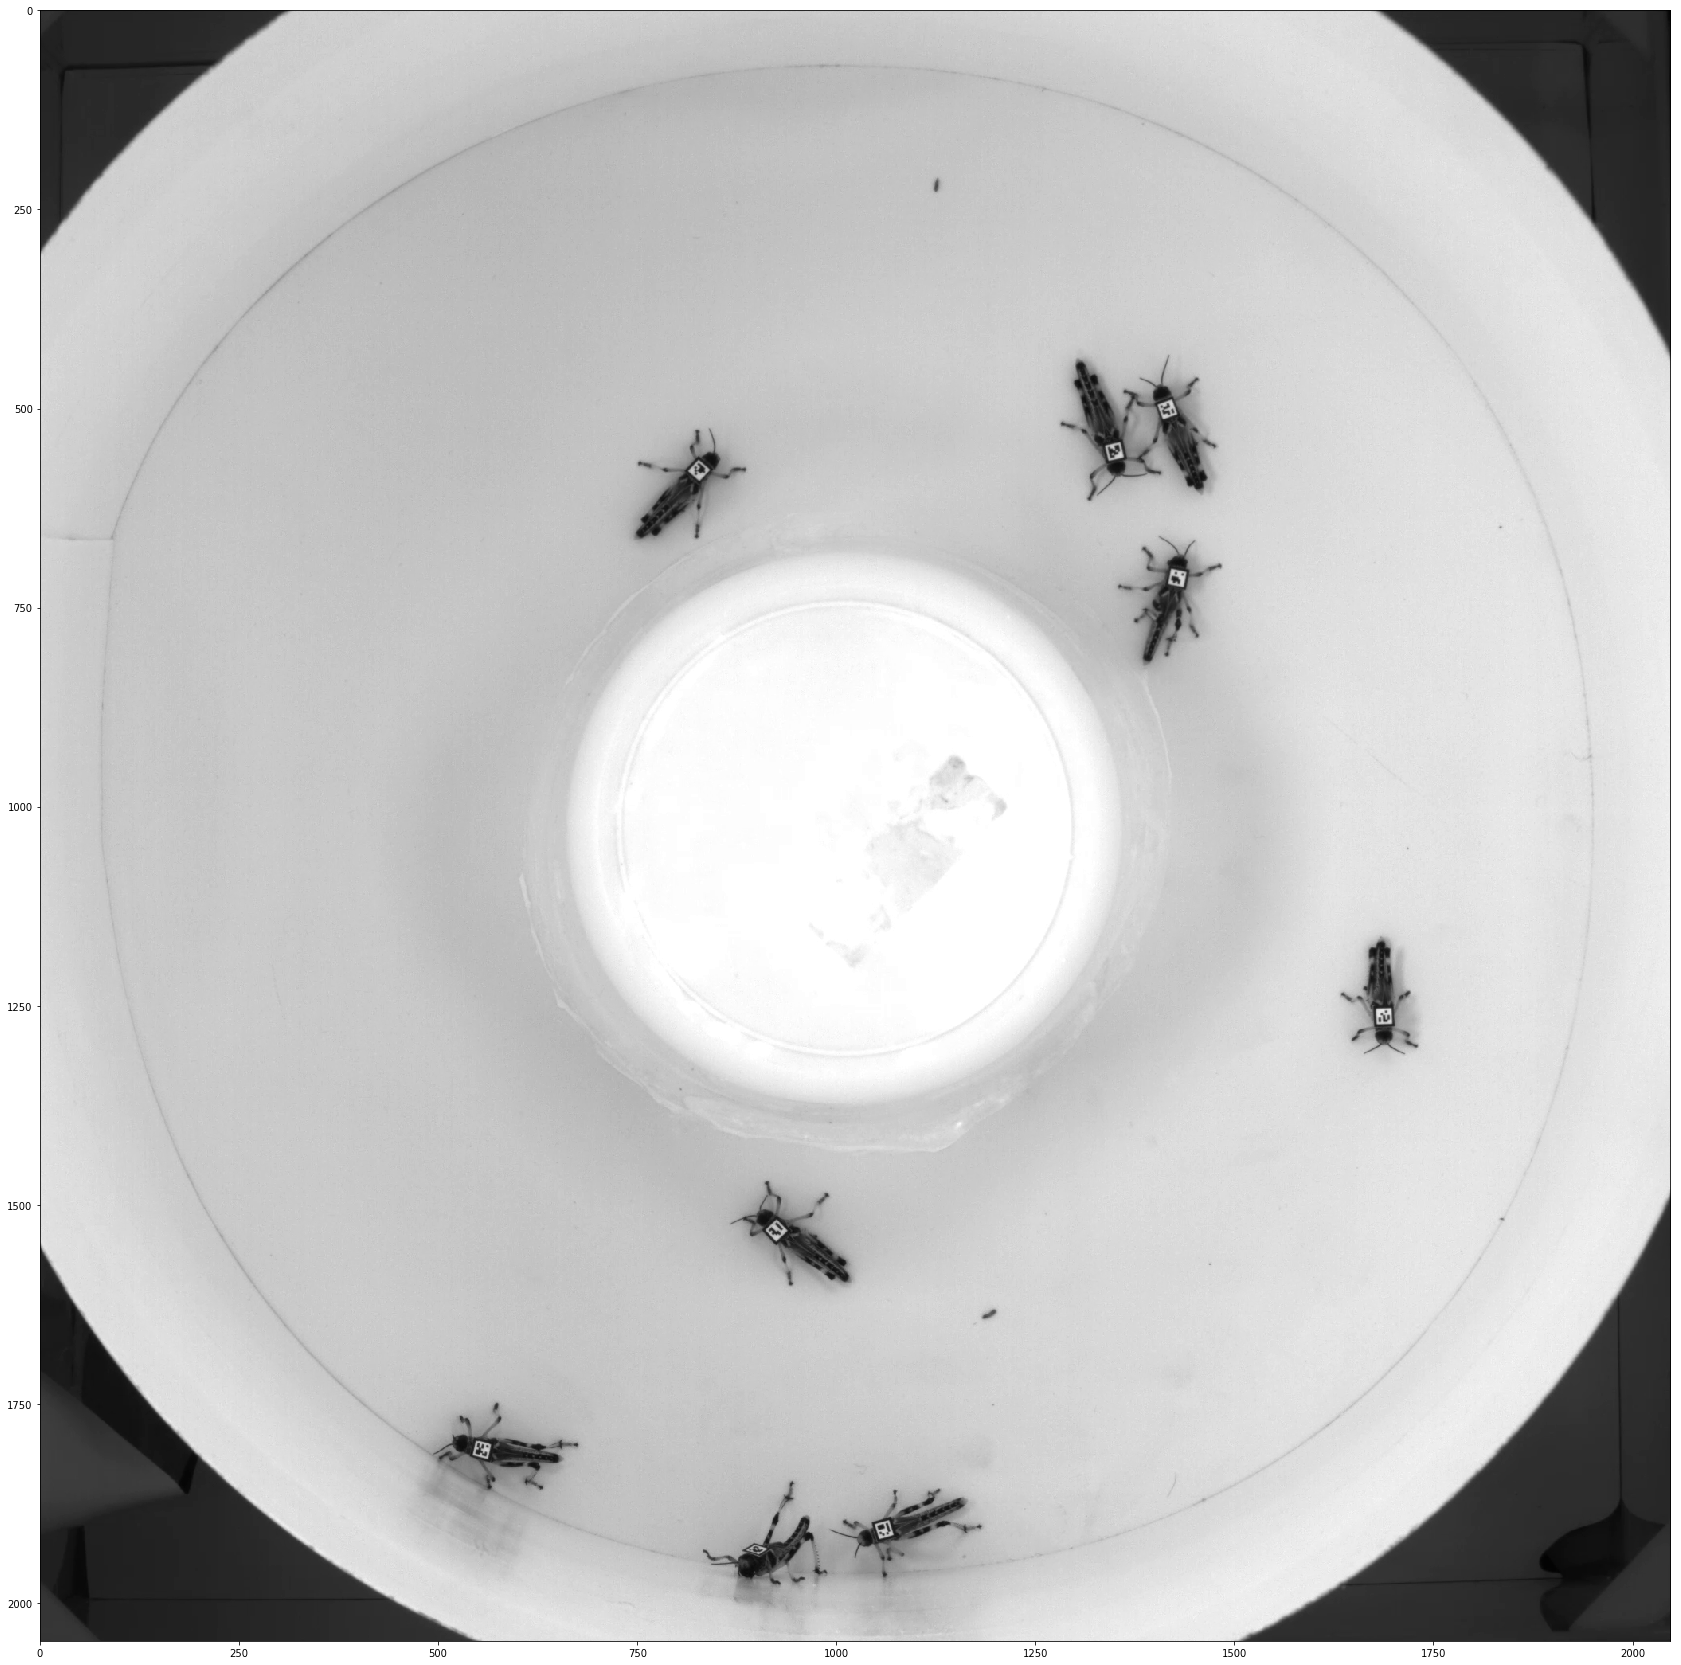

In [493]:
plt.figure(figsize=(30,30))
plt.imshow(frame, cmap='gray', interpolation='none')
plt.show()

In [8]:
dst = get_warp_dst(max_side=7)

In [9]:
import time

In [10]:
from sklearn.preprocessing import normalize

In [10]:
def preprocess_barcodes(pixels_array, std_thresh=25, barcode_shape=(7,7)):
    
    std_devs = np.std(pixels_array, 1)
    for idx,(pixels,std) in enumerate(zip(pixels_array,std_devs)):
        if std > std_thresh:
            ret, pixels = cv2.threshold(pixels,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            pixels = pixels.reshape((7,7))
            zeros = np.zeros_like(pixels)
            zeros[1:-1,1:-1] = 1
            pixels[zeros == 0] = 255
        pixels = pixels.flatten()
        pixels_array[idx] = pixels
        
    return pixels_array

In [11]:
t0 = time.time()
for frame in frames:
    gray = get_grayscale(frame, channel='green')
    gray = np.flipud(gray)
    #gray = cv2.resize(gray, (0,0), None, fx=1.5, fy=1.5)
    thresh = get_threshold(gray, block_size=1001, offset=80)
    contours = get_contours(thresh)
    points_array, pixels_array = get_candidate_barcodes(gray, contours, (7,7), 100, 10000, -1, 1, thresh.shape[1]-1, thresh.shape[0]-1, 0.07, 7, dst)
    candidate_points = points_array
    #pixels_array = normalize(pixels_array, norm='max')
    std_devs = np.std(pixels_array, 1)
    for idx,(pixels,std) in enumerate(zip(pixels_array,std_devs)):
        if std > 25:
            ret, pixels = cv2.threshold(pixels,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            pixels = pixels.reshape((7,7))
            zeros = np.zeros_like(pixels)
            zeros[1:-1,1:-1] = 1
            pixels[zeros == 0] = 255
        pixels = pixels.flatten()
        pixels_array[idx] = pixels
    #pixels_array = pixels_array.reshape((-1, 7,7))
    #zeros_array = np.zeros_like(pixels_array)
    #zeros_array[:,1:-1,1:-1] = 1
    #pixels_array[zeros_array == 0] = 1
    #pixels_array = pixels_array.reshape(-1, 49)
    points_array, best_IDs, correlations = match_barcodes(points_array, pixels_array, master_list, IDs, np.arange(len(IDs)), -5)
t1 = time.time()
dt = t1 - t0
fps = len(frames)/dt
print fps

NameError: name 'time' is not defined

In [4]:
#! /usr/bin/env python

"""
Copyright 2015-2017 Jacob M. Graving <jgraving@gmail.com>

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

	http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.pairwise import pairwise_distances
from types import BooleanType, IntType, StringType, FloatType, NoneType, TupleType
#from .utils import rotate_tag90, add_border


def pairwise_distance_check(X, Y=None, distance=5, metric='cityblock', n_jobs=1):
	""" Check the pairwise distances between two arrays.
	
	Parameters
	----------
	X : array
		Array of flattened barcodes.
	Y : array
		Array of flattened barcodes.
	distance : float
		Minimum distance between all barcodes in X and Y.
		
	Returns
	-------
	test : bool
		Returns True if all elements are greater than the minimum distance.
	
	"""
	D = pairwise_distances(X, Y, metric=metric, n_jobs=n_jobs)
	D[D < distance] = 0
	D[D >= distance] = 1

	if type(Y) == np.ndarray:
		if D.sum() == D.size:
			test = True
		else:
			test = False
	
	elif type(Y) == NoneType:
		if D.sum() == D.size - D.shape[0]:
			test = True
		else:
			test = False
	
	return test

def add_white_border(master_list, tag_shape, white_width):
	
		bordered = []
		for tag in master_list:
			new_tag = add_border(tag, tag_shape, white_width=white_width, black_width=0)
			bordered.append(new_tag)
		bordered = np.array(bordered)

		return bordered
	
def get_id_list(ntags):
    
	id_list = []
	for idx in range(ntags):
		ID = [idx,idx,idx,idx]
		id_list.append(ID)

	id_list = np.array(id_list) + 1
	id_list = id_list.flatten()

	return id_list

class TagDictionary:

	"""A class for generating, saving, loading, and printing 2-D barcode tags.

		Parameters
		----------
		tag_shape : tuple of int, default = (5,5)
			Shape of the barcodes to generate.
		distance : float, default = 7
			Minimum distance between barcodes
		white_width : int, default = 1
			Width of white border in bits.
		black_width : int, default = 1
			Width of black border in bits.
		niter : int, default = 99999
			Number of iterations to try.
		metric : str, default = 'cityblock'
			The distance metric to use for generating the barcodes.
		"""
    
	def __init__(self, tag_shape = (5,5), distance = 7, white_width = 1, black_width = 1, metric='cityblock'):

		self.tag_shape = tag_shape
		self.distance = distance
		self.metric = metric
		self.white_width = white_width
		self.white_shape = tuple([x+(self.white_width*2) for x in self.tag_shape])
		self.black_width = black_width
		self.black_shape = tuple([x+(self.white_width*2)+(self.black_width*2) for x in self.tag_shape])

		self.first_tag = True # start with first tag
		self.tag_len = self.tag_shape[0]*self.tag_shape[1] # get length of flattened tag

		self.master_list = None
		self.loaded = False
		self.saved = False

	def generate_dict(self, niter = 99999, verbose = False, reset_seed = True, n_jobs=1):
		"""Start generating barcode tags. Speed depends on hardware, tag size, and the number of iterations. This may take a few minutes."""
		
		self.niter = niter
		if reset_seed == True:
			new_seed = np.random.randint(0, 32768)
			np.random.seed(new_seed)
			self.random_seed = new_seed

		if verbose:
			print "Generating tags. This may take awhile..."

		for idx in np.arange(0, self.niter + 1): # generate some tags

			if verbose and idx % 10000 == 0 and idx > 0 and type(self.master_list) != NoneType:
				print "Iteration: " + str(idx) + "/" + str(self.niter)
				print "Tags found: ", len(self.master_list)//4

			if verbose and idx == self.niter and type(self.master_list) != NoneType:
				print "Iteration: " + str(idx) + "/" + str(self.niter)
				print "Tags found: ", len(self.master_list)//4

			new_tag = np.random.randint(0,2, size=(self.tag_len)).astype(np.uint8) # randomly generate a tag

			# get tag rotations
			tag_90 = rotate_tag90(new_tag, self.tag_shape, 1) 
			tag_180 = rotate_tag90(new_tag, self.tag_shape, 2)
			tag_270 = rotate_tag90(new_tag, self.tag_shape, 3)
			tag_list = np.asarray([new_tag, tag_90, tag_180, tag_270]).astype(np.uint8)

			# check distance between tag and rotations
			test = pairwise_distance_check(tag_list, distance=self.distance, metric=self.metric, n_jobs=n_jobs)

			if test: # if tag and all rotations are different enough from each other...

				if self.first_tag == True:
					self.master_list = tag_list
					self.first_tag = False # done with first tag

				elif self.first_tag == False:
					
					# check distance between all tag rotations and master list of tags
					test = pairwise_distance_check(X=tag_list, Y=self.master_list, distance=self.distance, metric=self.metric, n_jobs=n_jobs)
					
					if test:  # if all tag rotations are different enough from master list...
						for tag in tag_list:
							tag = np.asarray([tag]).astype(np.uint8)
							self.master_list = np.append(self.master_list, tag, axis=0) 

		self.ntags = self.master_list.shape[0]//4

		self.id_list = get_id_list(self.ntags)
	
		if verbose:
			print "Done!"
            
		self.barcode_list = add_white_border(self.master_list, self.tag_shape, self.white_width)
        
		return self
		
	def save_dict(self, filename = "master_list.pkl"):

		"""Save configuration as ``.pkl`` file.

		Parameters
		----------
		filename : str, default = "master_list.pkl"
			Path to save file, must be '.pkl' extension

		Returns
		-------
		saved : bool
			Saved successfully.
	"""
		config = {  "master_list" : self.master_list,
					"id_list" : self.id_list, 
					"tag_shape" : self.tag_shape, 
					"distance" : self.distance, 
					"white_width" : self.white_width, 
					"black_width" : self.black_width, 
				 }

		output = open(filename, 'wb')

		try:
			pickle.dump(config, output)
		except:
			raise IOError("File must be '.pkl' extension")

		output.close()

		self.saved = True

		return self.saved

	def load_dict(self, filename = "master_list.pkl"):

		"""Load configuration from a ``.pkl`` file.

		Parameters
		----------
		filename : str, default = "master_list.pkl"
			Path to load file, must be '.pkl' extension

		Returns
		-------
		loaded : bool
			Loaded successfully.
		"""

		# Open and load file
		pkl_file = open(filename, 'rb')

		try:
			config = pickle.load(pkl_file)
		except:
			raise IOError("File must be '.pkl' extension")

		pkl_file.close()

		# Load new configuration
		self.master_list = config["master_list"]
		self.id_list = config["id_list"]
		self.tag_shape = config["tag_shape"]
		#self.distance = config["distance"]
		self.white_width = config["white_width"]
		self.black_width = config["black_width"]
		self.white_shape = tuple([x+(self.white_width*2) for x in self.tag_shape])
		self.black_shape = tuple([x+(self.white_width*2)+(self.black_width*2) for x in self.tag_shape])
		self.ntags = self.master_list.shape[0]//4
		self.id_index = np.arange(len(self.id_list))
		self.tag_len = self.tag_shape[0]*self.tag_shape[1]

		self.barcode_list = add_white_border(self.master_list, self.tag_shape, self.white_width)

		self.loaded = True

		return self.loaded


	def print_tags(self, filename, ntags = 200, page_size = (8.26, 11.69), ncols = 20, id_fontsize = 5, arrow_fontsize = 10, id_digits = 4, show = True):

		"""Print tags as image file or PDF. Default settngs are for ~6-mm wide tags.

		Parameters
		----------
		filename : str
			Location for saving the barcode images, must be vector graphic (`.pdf`, '.svg', '.eps') or image (`.png`, `.jpg`, etc.) file extension.
		ntags : int, default = 200
			Number of tags per page.
		page_size : tuple of float, default = (8.26, 11.69)
			Size of the printed page, default is A4. 
		ncols : int, default = 20
			Number of columns.
		id_fontsize : int, default = 5
			Font size for ID number.
		arrow_fontsize : int, default = 10
			Font size for arrow.
		id_digits : int, default = 5
			Number of digits for ID number printed below barcode (zero pads the left side of the number).
		show : bool
			Show the figure using plt.show()

		"""

		self.fig = plt.figure(figsize = page_size)
		plot = 1
		for idx, tag in enumerate(self.master_list):
			if (idx+1) % 4 == 0 and plot <= ntags:

				tag = add_border(tag, self.tag_shape, self.white_width, self.black_width)
				tag = tag.reshape(self.black_shape)

				ax = plt.subplot(ntags//ncols, ncols, plot)
				tag_number = str((idx+1)/4)

				if len(tag_number) < id_digits:
					tag_number = "0"*(id_digits-len(tag_number)) + tag_number
				
				ax.set_title(u"\u2191", fontsize = arrow_fontsize, family = "Arial", weight = "heavy")
				ax.set_xlabel(tag_number, fontsize = id_fontsize, family = "Arial", weight = 'light', color = 'white', backgroundcolor = 'black', bbox = {'fc': 'black', 'ec': 'none'})
				ax.set_aspect(1)
				ax.xaxis.set_ticks_position('none')
				ax.yaxis.set_ticks_position('none')
				ax.get_xaxis().set_ticks([])
				ax.get_yaxis().set_ticks([])
				ax.xaxis.set_label_coords(0.5, -0.1)

				ax.imshow(tag, cmap='gray', interpolation = 'nearest', zorder = 200)

				plot += 1

		plt.savefig(filename, dpi=600, interpolation = 'none')

		if show == True:
			plt.show()

		return True

In [5]:
tags = TagDictionary(distance=9, metric='cityblock')

In [6]:
#tags.generate_dict(niter=999999, verbose=True)

In [7]:
#tags.print_tags('test.eps')

In [8]:
X = np.random.random((10,200))
X.min(0).shape

(200,)

In [14]:
@jit(nopython = True)
def _order_points(points):

	# Check for clockwise order with crossproduct
	dx1 = points[1,0] - points[0,0]
	dy1 = points[1,1] - points[0,1]
	dx2 = points[2,0] - points[0,0]
	dy2 = points[2,1] - points[0,1]
	cross_product = (dx1 * dy2) - (dy1 - dx2)

	if cross_product < 0.0: # if not clockwise, reorder middle points
		clockwise = points.copy()
		clockwise[1] = points[3]
		clockwise[3] = points[1]
	else:
		clockwise = points
		
	x_sorted = clockwise[np.argsort(clockwise[:, 0]), :] # sort by x-coords
	left = x_sorted[:2,:] # get left side coordinates
	left = left[np.argsort(left[:, 1]), :] # sort left coords by y-coords
	top_left = left[0] # get top left corner
	
	top_left_condition = (clockwise[:,0] == top_left[0]) & (clockwise[:,1] == top_left[1])
	top_left_index = np.where(top_left_condition)[0][0] #get original location for top left corner
	
	#reorder from the top left corner
	if top_left_index == 0:
		ordered = clockwise
	elif top_left_index == 1:
		ordered = clockwise.copy()
		ordered[0] = clockwise[1]
		ordered[1] = clockwise[2]
		ordered[2] = clockwise[3]
		ordered[3] = clockwise[0]
	elif top_left_index == 2:
		ordered = clockwise.copy()
		ordered[0] = clockwise[2]
		ordered[1] = clockwise[3]
		ordered[2] = clockwise[0]
		ordered[3] = clockwise[1]
	elif top_left_index == 3:
		ordered = clockwise.copy()
		ordered[0] = clockwise[3]
		ordered[1] = clockwise[0]
		ordered[2] = clockwise[1]
		ordered[3] = clockwise[2]

	return ordered
	
def order_points(points):

	""" 
	Order 4x2 array in clockwise order from top-left corner.

	Parameters
	----------
	points : array_like
		4x2 array of points to order.
		
	Returns
	-------
	ordered : ndarray
		Points ordered clockwise from top-left corner.
	
	"""
	if type(points) != np.ndarray:
		raise TypeError("points must be numpy array")
	if points.ndim != 2:
		raise ValueError("points must be 2-D array")
	if points.shape != (4,2):
		raise ValueError("points must be 4x2 array")
	if points.dtype != np.dtype(np.float32):
		points = points.astype(np.float32)
		
	ordered = _order_points(points)
	
	return ordered

def get_grayscale(color_image, channel = None):

	""" 
	Returns single-channel grayscale image from 3-channel BGR color image.

	Parameters
	----------
	color_image : (MxNx3) numpy array
		3-channel BGR-format color image as a numpy array
	channel : {'blue', 'green', 'red', 'none', None}, default = None
		The color channel to use for producing the grayscale image.
		
	Returns
	-------
	gray_image : (MxNx1) numpy array
		Single-channel grayscale image as a numpy array.

	Notes
	----------
	For channel, None uses the default linear transformation from OpenCV: Y = 0.299R + 0.587G + 0.114B
	Channels 'blue', 'green', and 'red' use the respective color channel as the grayscale image. 
	Under white ambient lighting, 'green' typically provides the lowest noise. Under red and infrared lighting, 'red' typically provides the lowest noise.

	"""
	if type(channel) not in [StringType, NoneType]:
		raise TypeError("Channel must be type str or None")
	if type(channel) is StringType and not (channel.startswith('b') or channel.startswith('g') or channel.startswith('r')):
		raise ValueError("Channel value must be 'blue', 'green', 'red', or None")
	if type(color_image) is not np.ndarray:
		raise TypeError("image must be a numpy array")


	if color_image.ndim != 3:
		raise ValueError("image must be color (MxNx3)")
	if color_image.shape[2] != 3:
		raise ValueError("image must have 3 color channels (MxNx3)")
	if color_image.dtype is not np.dtype(np.uint8):
		raise TypeError("image array must be dtype np.uint8")

	if channel.startswith('b'):
		gray_image, _, _ = cv2.split(color_image)
	elif channel.startswith('g'):
			_, gray_image, _ = cv2.split(color_image)
	elif channel.startswith('r'):
		_, _, gray_image = cv2.split(color_image)
	elif channel is None:
		gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

	return gray_image

def get_threshold(gray_image, block_size = 101, offset = 0):

	""" 
	Returns binarized thresholded image from single-channel grayscale image.

	Parameters
	----------
	gray_image : (MxNx1) numpy array
		Single-channel grayscale image as a numpy array
	block_size : int, default = 1001
		Odd value integer. Size of the local neighborhood for adaptive thresholding.
	offset : default = 2
		Constant subtracted from the mean. Normally, it is positive but may be zero or negative as well. 
		The threshold value is the mean of the block_size x block_size neighborhood minus offset.

	Returns
	-------
	threshold_image : (MxNx1) numpy array
		Binarized (0, 255) image as a numpy array.

	"""

	if block_size % 2 != 1:
		raise ValueError("block_size must be an odd value (block_size % 2 == 1)")
	if type(offset) not in [IntType, FloatType]:
		raise TypeError("offset must be type int or float")
	if type(gray_image) is not np.ndarray:
		raise TypeError("image must be a numpy array")
	if gray_image.ndim != 2:
		raise ValueError("image must be grayscale")
	if gray_image.dtype is not np.dtype(np.uint8):
		raise TypeError("image array must be dtype np.uint8")

	threshold_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, offset)

	return threshold_image

def get_contours(threshold_image):

	""" 
	Returns a list of contours from a binarized thresholded image.

	Parameters
	----------
	threshold_image : (MxNx1) numpy array
		Binarized threshold image as a numpy array

	Returns
	-------
	contours : list
		List of contours extracted from threshold_image.

	"""
	#if len(set([0, 255]) - set(np.unique(threshold_image))) != 0:
		#raise ValueError("image must be binarized to (0, 255)")

	_, contours, _ = cv2.findContours(threshold_image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

	return contours

def get_polygon(contour, tolerance=0.1):

	""" 
	Returns a polygonal approximation of a contour.

	Parameters
	----------
	contour : array_like
		Contour to fit a polygon to
	tolerance : int or float, default = 0.1
		Tolerance for fitting a polygon as a proportion of the perimeter of the contour. 
		This value is used to set epsilon, which is the maximum distance between the original contour 
		and its polygon approximation. Higher values decrease the number of vertices in the polygon.
		Lower values increase the number of vertices in the polygon. This parameter affects 
		how many many contours reach the barcode matching algorithm, 
		as only polygons with 4 vertices are used.
	Returns
	-------
	polygon : ndarray
		The fitted polygon.
	polygon_area : float
		The signed area of the polygon
	perimeter : float
		The perimeter of the contour
		

	"""
	perimeter = cv2.arcLength(contour, True)
	polygon = cv2.approxPolyDP(contour, tolerance * perimeter, True)
	polygon_area = cv2.contourArea(polygon, True)

	return (polygon, polygon_area, perimeter)

def test_edge_proximity(contour, edge_proximity, x_proximity, y_proximity):

	""" 
	Test if a contour is too close to the edge of the frame to read.

	Parameters
	----------
	contour : array_like
		Contour to test
	edge_proximity : int, default = 1
		The threshold in pixels for how close a contour can be to the edge. 
		Default is 1 pixel
	x_proximity : int
		The threshold in pixels for how close a contour can be to the x-axis border.
		This should correspond to frame_width - edge_proximity, but is precalculated for speed
	y_proximity : int 
		The threshold in pixels for how close a contour can be to the y-axis border.
		This should correspond to frame_height - edge_proximity, but is precalculated for speed

	Returns
	-------
	edge_proximity_test : bool
		Returns False if the contour is far enough away from the edge of the frame

	"""
	contour_reshape = np.squeeze(contour)
	contour_x = contour_reshape[:,0]
	contour_y = contour_reshape[:,1]
	flat = contour.flatten()

	edge_zero = np.sum(flat <= edge_proximity)
	edge_x = np.sum(contour_x >= x_proximity)
	edge_y = np.sum(contour_y >= y_proximity)

	if edge_zero == 0 and edge_x == 0 and edge_y == 0:
		edge_proximity_test = False
	else:
		edge_proximity_test = True

	return edge_proximity_test

def get_pixels(image, points, template, max_side):

	""" 
	Use affine transform to extract pixel values of candidate barcodes from an image.

	Parameters
	----------
	image : array_like
		Grayscale image from which to extract pixel values
	points : array_like
		An array of coordinates corresponding to the four corners of the candidate barcode
	template : array_like
		A template for storing the extracted pixels. 
		This should be precalculated using get_tag_template()
	max_side : int 
		The size of the template in pixels

	Returns
	-------
	pixels : ndarray
		The extracted pixel values

	"""
	M = cv2.getPerspectiveTransform(points.reshape((4,1,2)).astype(np.float32), template)
	pixels = cv2.warpPerspective(image, M, (max_side, max_side), flags = (cv2.INTER_LINEAR), borderValue = 255)

	return pixels

def get_points(polygon):
	""" 
	Sort corners of a candidate barcode clockwise from the top-left corner.

	Parameters
	----------
	polygon : array_like, shape (4,1,2)
		A polygon with four coordinates to sort

	Returns
	-------
	points : ndarray
		The coordinates sorted clockwise from the top-left corner.

	"""

	polygon = np.squeeze(polygon)
	points = order_points(polygon)
	points = polygon.reshape((1,4,2))

	return points

def test_area(area, area_min, area_max, area_sign):

	"""
	Test the area of a candidate barcode.

	Parameters
	----------
	area : float
		The area of the candidate barcode
	area_min : float
		Minimum area
	area_max : float
		Maximum area
	area_sign : +1 or -1
		The sign of the area

	Returns
	-------
	area_test : bool
		Returns True if sign is correct and area is within range.

	"""
	if np.sign(area) == area_sign and area_min <= np.abs(area) <= area_max:
		area_test = True
	else:
		area_test = False

	return area_test

def test_quad(polygon, polygon_area, area_min, area_max, area_sign):
	"""
	Test if a polygon is a quadrilateral.

	Parameters
	----------
	polygon : array_like, shape (4,1,2)
		A polygon to test
	polygon_area : float
		The area of the candidate barcode
	area_min : float
		Minimum area
	area_max : float
		Maximum area
	area_sign : +1 or -1
		The sign of the area

	Returns
	-------
	quad_test : bool
		Returns True if the polygon is a quadrilateral.

	"""

	# if 4 vertices, sign is correct, value is within range, and polygon is convex...
	if (polygon.shape[0] == 4 
		and test_area(polygon_area, area_min, area_max, area_sign)
		and cv2.isContourConvex(polygon)):

		quad_test = True

	else:
		quad_test = False

	return quad_test

def get_area(contour):

	""" 
	Calculate the signed area of a contour.

	Parameters
	----------
	contour : array_like
		Contour to calculate the area for

	Returns
	-------
	area : int
		The signed area of a contour
	"""
	area = cv2.contourArea(contour, True)
	
	return area

def test_geometry(contour, area_min, area_max, area_sign, edge_proximity, x_proximity, y_proximity, tolerance):

	"""
	Test the geometry of a contour. Return the corners if it is a candidate barcode.

	Parameters
	----------
	contour : array_like
		The contour to test
	area_min : float
		Minimum area
	area_max : float
		Maximum area
	area_sign : +1 or -1
		The sign of the area
	edge_proximity : int, default = 1
		The threshold in pixels for how close a contour can be to the edge. 
		Default is 1 pixel
	x_proximity : int
		The threshold in pixels for how close a contour can be to the x-axis border.
		This should correspond to frame_width - edge_proximity, but is precalculated for speed
	y_proximity : int 
		The threshold in pixels for how close a contour can be to the y-axis border.
		This should correspond to frame_height - edge_proximity, but is precalculated for speed
	tolerance : int or float, default = 0.1
		Tolerance for fitting a polygon as a proportion of the perimeter of the contour. 
		This value is used to set epsilon, which is the maximum distance between the original contour 
		and its polygon approximation. Higher values decrease the number of vertices in the polygon.
		Lower values increase the number of vertices in the polygon. This parameter affects 
		how many many contours reach the barcode matching algorithm, 
		as only polygons with 4 vertices are used.
		
	Returns
	-------
	geometry_test : bool
		Returns True if the contour is a candidate barcode.
	polygon : ndarray
		The polygon approximation of the contour
	"""

	geometry_test = False
	polygon = np.zeros((0,4,2))

	if contour.shape[0] >= 4:

		edge_proximity_test = test_edge_proximity(contour, edge_proximity, x_proximity, y_proximity)

		if edge_proximity_test == False:

			contour_area = get_area(contour) # calculate the signed area

			if test_area(contour_area, area_min, area_max, area_sign): # if the sign is correct and value is within range...
				
				(polygon, polygon_area, perimeter) = get_polygon(contour, tolerance)
				peri_area_ratio = perimeter/contour_area

				if 100 > np.abs(peri_area_ratio) > 0:  # if perimeter_area_ratio is reasonable value...

					geometry_test = test_quad(polygon, polygon_area, area_min, area_max, area_sign)

	return (geometry_test, polygon)


def get_candidate_barcodes(image, contours, barcode_shape, area_min, area_max, area_sign, edge_proximity, x_proximity, y_proximity, tolerance, template, max_side):

	"""
	Find candidate barcodes in an image.

	Parameters
	----------
	image : array_like, shape (n_rows, n_cols, 1)
		An image containing barcodes
	contours : list
		A list of contours from cv2.contours()
	barcode_shape : tuple
		The shape of the barcode with white border
	area_min : float
		Minimum area
	area_max : float
		Maximum area
	area_sign : +1 or -1
		The sign of the area
	edge_proximity : int, default = 1
		The threshold in pixels for how close a contour can be to the edge. 
		Default is 1 pixel
	x_proximity : int
		The threshold in pixels for how close a contour can be to the x-axis border.
		This should correspond to frame_width - edge_proximity, but is precalculated for speed
	y_proximity : int 
		The threshold in pixels for how close a contour can be to the y-axis border.
		This should correspond to frame_height - edge_proximity, but is precalculated for speed
	tolerance : int or float, default = 0.1
		Tolerance for fitting a polygon as a proportion of the perimeter of the contour. 
		This value is used to set epsilon, which is the maximum distance between the original contour 
		and its polygon approximation. Higher values decrease the number of vertices in the polygon.
		Lower values increase the number of vertices in the polygon. This parameter affects 
		how many many contours reach the barcode matching algorithm, as only polygons with 4 vertices are used.
	template : array_like
		A template for storing the extracted pixels. 
		This should be precalculated using get_tag_template()
	max_side : int 
		The size of the template in pixels

	Returns
	-------
	points_array : ndarray, shape (n_samples, 4, 2)
		Array of coordinates for candidate barcodes.
	pixels_array : ndarray, shape (n_samples, barcode_shape[0]*barcode_shape[1])
		Array of flattened pixels for candidate barcodes
	"""

	points_array = np.zeros((0, 4, 2), dtype=np.int32)
	pixels_array = np.zeros((0, barcode_shape[0]*barcode_shape[1]), dtype=np.uint8)

	if len(contours) > 0: # if contours are found
					
		for (idx,contour) in enumerate(contours): # iterate over the list of contours

			(geometry_test, polygon) = test_geometry(contour, area_min, area_max, area_sign, edge_proximity, x_proximity, y_proximity, tolerance)
			
			if geometry_test == True:
				points = get_points(polygon)
				pixels = get_pixels(image, points, template, max_side).reshape((1,-1))

				points_array = np.append(points_array, points, axis = 0)
				pixels_array = np.append(pixels_array, pixels, axis = 0)

	return (points_array, pixels_array)

def match_barcodes(points_array, pixels_array, barcode_nn, id_list, id_index, distance_threshold):
	
	"""
	Match candidate barcodes

	Parameters
	----------
	points_array : array_like, shape (n_samples, 4, 2)
		Array of coordinates for candidate barcodes
	pixels_array : array_like, shape (n_samples, n_pixels)
		Array of flattened pixels for candidate barcodes
	barcode_nn : NearestNeighbors class
		A NearestNeighbors class from sci-kit learn fitted to a list of barcodes.
		See sklearn.neighbors.NearestNeighbors for details
	id_list : array_like
		An array of known identities corresponding to the list of barcodes in barcode_nn
	id_index : array_like
		An array of indices corresponding to id_list
	distance_threshold : float
		The maximum distance between a barcode candidate and its matched identity


	Returns
	-------
	points_array : ndarray, shape (n_samples, 4, 2)
		Array of coordinates for matched barcodes.
	pixels_array : ndarray, shape (n_samples, barcode_shape[0]*barcode_shape[1])
		Array of flattened pixels for matched barcodes
	best_id_list : ndarray
		Array of identities for matched barcodes
	best_id_index : ndarray
		Array of indices corresponding to best_id_list
	distances : ndarray
		Array of distances for matched barcodes
	"""
    
	distances, index = barcode_nn.kneighbors(pixels_array//255, n_neighbors=1)
	distances = distances[:,0]
	index = index[:,0]
	
	pixel_index = np.where(distances < distance_threshold)
	distances = distances[pixel_index]
	index = index[pixel_index]

	points_array = points_array[pixel_index]
	pixels_array = pixels_array[pixel_index]

	best_id_list = id_list[index]
	best_id_index = id_index[index]

	return (points_array, pixels_array, best_id_list, best_id_index, distances)

@jit(nopython=True)
def sort_corners(points_array, best_id_index):
	"""
	Sort coordinates of matched barcode corners in clockwise order from the true top-left corner
	(taking into account the orientation of the tag).

	Parameters
	----------
	points_array : array_like, shape (n_samples, 4, 2)
		Array of coordinates for candidate barcodes
	best_id_index : ndarray
		Array of indices corresponding to best_id_list

	Returns
	-------
	points_array : ndarray, shape (n_samples, 4, 2)
		Array of sorted coordinates for matched barcodes
	"""

	for idx in range(points_array.shape[0]):
        
		points = points_array[idx]
		best_index = best_id_index[idx]
		rotation_test = best_index % 4
		
		tl = points[0]
		tr = points[1]
		br = points[2]
		bl = points[3]
		
		corners = np.empty_like(points)

		if rotation_test == 3:
			corners = points

		if rotation_test == 0:
			corners[0] = bl
			corners[1] = tl
			corners[2] = tr
			corners[3] = br

		if rotation_test == 1:
			corners[0] = br
			corners[1] = bl
			corners[2] = tl
			corners[3] = tr

		if rotation_test == 2:
			corners[0] = tr
			corners[1] = br
			corners[2] = bl
			corners[3] = tl

		points_array[idx] = corners

	return points_array

def get_tag_template(max_side):
	"""
	Create a template for extracting barcode pixels using affine transform.
	
	Parameters
	----------
	max_side : int 
		The size of the template in pixels
	Returns
	-------
	template : array_like
		A template for storing extracted barcode pixels. 
	
	"""
	
	length = max_side - 1
	template = np.array([[0, 0],
					[length, 0],
					[length, length],
					[0, length]],
					dtype = "float32")

	return template

def test_pixel_variance(points_array, pixels_array, var_thresh=500):
	"""
	Test pixel variance of each barcode and return only those with variance higher than a set threshold.
	Low variance typically means the candidate barcode is a white or black blob and not an actual barcode.
	
	Parameters
	----------
	points_array : ndarray, shape (n_samples, 4, 2)
		Array of coordinates for candidate barcodes
	pixels_array : ndarray, shape (n_samples, n_pixels)
		Array of flattened pixels for candidate barcodes
	var_thresh : float, (default = 500)
		Minimum variance threshold
			
	Returns
	-------
	points_array : ndarray, shape (n_samples, 4, 2)
		Array of coordinates for candidate barcodes with variance higher than var_thresh
	pixels_array : ndarray, shape (n_samples, 4, 2)
		Array of flattened pixels for candidate barcodes with variance higher than var_thresh
	"""

	variances = np.var(pixels_array, axis=1)
	variance_index = np.where(variances >= var_thresh)
	pixels_array = pixels_array[variance_index]
	points_array = points_array[variance_index]

	return (points_array, pixels_array)

def otsu_threshold(pixels_array):
	"""
	Threshold barcode pixels using Otsu's method. The algorithm assumes the image
	contains two classes of pixels following a bimodal histogram. It calculates the
	optimum threshold separating the two classes so that their combined intra-class variance
	is minimal and their inter-class variance is maximal. 
	
	Parameters
	----------
	pixels_array : ndarray, shape (n_samples, n_pixels)
		Array of flattened pixels for candidate barcodes
			
	Returns
	-------
	pixels_array : ndarray, shape (n_samples, n_pixels)
		Array of flattened pixels for candidate barcodes binarized to 0,255
	"""
	for idx,pixels in enumerate(pixels_array):
		ret, pixels = cv2.threshold(pixels,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
		pixels = np.squeeze(pixels)
		pixels_array[idx] = pixels
		
	return pixels_array

def whiten_edge_pixels(pixels_array, barcode_shape, white_width):
	"""
	Replace edge around the barcode pixels with white pixels for matching.
	
	Parameters
	----------
	pixels_array : ndarray, shape (n_samples, n_pixels)
		Array of flattened pixels for candidate barcodes
	barcode_shape : tuple
		The shape of the barcode with white border
	white_width : int
		The bit width of the white border around the barcode
	Returns
	-------
	pixels_array : ndarray, shape (n_samples, n_pixels)
		Array of flattened pixels for candidate barcodes with white edges
	"""
	pixels_array = pixels_array.reshape((pixels_array.shape[0], barcode_shape[0], barcode_shape[1]))
	edge_array = np.ones_like(pixels_array)
	edge_array[:, white_width:-white_width, white_width:-white_width] = 0
	pixels_array[edge_array == 1] = 255
	pixels_array = pixels_array.reshape((pixels_array.shape[0], barcode_shape[0]*barcode_shape[1]))
	
	return pixels_array

def preprocess_pixels(points_array, pixels_array, var_thresh, barcode_shape, white_width):
	"""
	Preprocess candidate barcode pixels before matching. 
	Test pixel variance, binarize the pixel values, and whiten the edge pixels for each barcode
	
	Parameters
	----------
	pixels_array : ndarray, shape (n_samples, n_pixels)
		Array of flattened pixels for candidate barcodes
			
	Returns
	-------
	points_array : ndarray, shape (n_samples, 4, 2)
		Array of coordinates for candidate barcodes
	pixels_array : ndarray, shape (n_samples, n_pixels)
		Array of flattened pixels for candidate barcodes with preprocessed pixels
	"""
	points_array, pixels_array = test_pixel_variance(points_array, pixels_array, var_thresh)
	if pixels_array.shape[0] > 0:
		pixels_array = otsu_threshold(pixels_array)
	if pixels_array.shape[0] > 0:
		pixels_array = whiten_edge_pixels(pixels_array, barcode_shape, white_width)

	return (points_array, pixels_array)

def process_frame(frame, channel, block_size, offset, barcode_shape, white_width, area_min, area_max, x_proximity, y_proximity, tolerance, template, max_side, var_thresh, barcode_nn, id_list, id_index, distance_threshold):
	"""
	Process a single frame to track barcodes. 
	
	Parameters
	----------
	frame : (MxNx3) numpy array
		3-channel BGR-format color image as a numpy array
	channel : {'blue', 'green', 'red', 'none', None}, default = None
		The color channel to use for producing the grayscale image.
	block_size : int, default = 1001
		Odd value integer. Size of the local neighborhood for adaptive thresholding.
	offset : default = 2
		Constant subtracted from the mean. Normally, it is positive but may be zero or negative as well. 
		The threshold value is the mean of the block_size x block_size neighborhood minus offset.
	barcode_shape : tuple
		The shape of the barcode with white border
	white_width : int
			The bit width of the white border around the barcode
	area_min : float
		Minimum area
	area_max : float
		Maximum area
	x_proximity : int
		The threshold in pixels for how close a contour can be to the x-axis border.
		This should correspond to frame_width - 1, but is precalculated for speed
	y_proximity : int 
		The threshold in pixels for how close a contour can be to the y-axis border.
		This should correspond to frame_height - 1, but is precalculated for speed
	tolerance : int or float, default = 0.1
		Tolerance for fitting a polygon as a proportion of the perimeter of the contour. 
		This value is used to set epsilon, which is the maximum distance between the original contour 
		and its polygon approximation. Higher values decrease the number of vertices in the polygon.
		Lower values increase the number of vertices in the polygon. This parameter affects 
		how many many contours reach the barcode matching algorithm, 
		as only polygons with 4 vertices are used.
	template : array_like
		A template for storing the extracted pixels. 
		This should be precalculated using get_tag_template()
	max_side : int 
		The size of the template in pixels
	var_thresh : float, (default = 500)
		Minimum variance threshold
	barcode_nn : NearestNeighbors class
		A NearestNeighbors class from sci-kit learn fitted to a list of barcodes.
		See sklearn.neighbors.NearestNeighbors for details
	id_list : array_like
		An array of known identities corresponding to the list of barcodes in barcode_nn
	id_index : array_like
		An array of indices corresponding to id_list
	distance_threshold : float
		The maximum distance between a barcode candidate and its matched identity

	Returns
	-------
	points_array : ndarray, shape (n_samples, 4, 2)
		Array of coordinates for barcodes
	pixels_array : ndarray, shape (n_samples, n_pixels)
		Array of flattened pixels for barcodes
	"""
	best_id_list = np.zeros((0,1))
	distances = np.zeros((0,1))
	
	gray = get_grayscale(frame, channel=channel)
	gray = np.flipud(gray)
	thresh = get_threshold(gray, block_size=block_size, offset=offset)
	contours = get_contours(thresh)

	points_array, pixels_array = get_candidate_barcodes(image=gray,
														contours=contours,
														barcode_shape=barcode_shape,
														area_min=area_min,
														area_max=area_max,
														area_sign=-1,
														edge_proximity=1,
														x_proximity=x_proximity,
														y_proximity=y_proximity,
														tolerance=tolerance,
														max_side=max_side,
														template=template
													   )
	
	if pixels_array.shape[0] > 0:
		points_array, pixels_array = preprocess_pixels(points_array=points_array,
														pixels_array=pixels_array,
														var_thresh=var_thresh,
														barcode_shape=barcode_shape,
														white_width=white_width
														)
	if pixels_array.shape[0] > 0:
		points_array, pixels_array, best_id_list, best_id_index, distances = match_barcodes(points_array=points_array,
																  pixels_array=pixels_array,
																  barcode_nn=barcode_nn,
																  id_list=id_list,
																  id_index=id_index,
																  distance_threshold=distance_threshold
																						   )
	if points_array.shape[0] > 0:                                                           
		points_array = sort_corners(points_array, best_id_index)
		
	return (gray, thresh, points_array, pixels_array, best_id_list, distances)

In [15]:
ret, frame = VideoReader("/Users/jake/Google Drive/taggedfish/seven_sunbleak_alone.mp4").read()

In [16]:
frame.shape

(2048, 2048, 3)

In [145]:
from sklearn.neighbors import NearestNeighbors

class Tracker(TagDictionary, VideoReader):
    
    def __init__(self, source, block_size=1001, offset=80, area_range=(10,10000), tolerance=0.1, distance_threshold=8, var_thresh=500, channel='green'):
        
        VideoReader.__init__(self, source)
        TagDictionary.__init__(self)
        self.area_min = area_range[0]
        self.area_max = area_range[1]
        self.tolerance = tolerance
        self.distance_threshold = distance_threshold
        self.block_size = block_size
        self.offset = offset
        self.channel = channel
        self.var_thresh = var_thresh
        self.frame_width = self.width()
        self.frame_height = self.height()
        self.x_proximity = self.frame_width-1
        self.y_proximity = self.frame_height-1

        
    def track(self, batch_size=8):
        
        self.barcode_shape = self.white_shape
        max_side=self.barcode_shape[0]
        template = get_tag_template(max_side)
        
        self.barcode_nn = NearestNeighbors(metric='correlation', algorithm='brute')
        self.barcode_nn.fit(self.barcode_list)
        #dists = []
        #while not self.finished():
        frames = self.read_batch(batch_size)
        for idx,frame in enumerate(frames):
            gray, thresh, points_array, pixels_array, best_id_list, distances = process_frame(frame=frame,
                                                                                       channel=self.channel,
                                                                                       block_size=self.block_size,
                                                                                       offset = self.offset,
                                                                                       barcode_shape=self.barcode_shape,
                                                                                       white_width=self.white_width,
                                                                                       area_min=self.area_min,
                                                                                       area_max=self.area_max,
                                                                                       x_proximity=self.x_proximity,
                                                                                       y_proximity=self.y_proximity,
                                                                                       tolerance=self.tolerance,
                                                                                       max_side=max_side,
                                                                                       template=template,
                                                                                       var_thresh=self.var_thresh,
                                                                                       barcode_nn=self.barcode_nn,
                                                                                       id_list=self.id_list,
                                                                                       id_index=self.id_index,
                                                                                       distance_threshold=self.distance_threshold,
                                                                                      )
                        
            #dists.append(distances)
        return (gray, thresh, pixels_array, points_array, best_id_list, distances)
        

In [146]:
tracker = Tracker("/Users/jake/Google Drive/taggedfish/seven_sunbleak_alone.mp4", block_size=201, offset=-40, distance_threshold=1-0.8, area_range=(100,10000), tolerance=0.07)

In [147]:
tracker.load_dict('/Users/jake/Google Drive/barcodes/robust_8bit_barcodes/master_list.pkl')

True

In [148]:
import time

In [153]:
t0 = time.time()
gray, thresh, pixels_array, points_array, best_id_list, distances = tracker.track(20)
t1 = time.time()
dt = t1-t0
fps = 100/dt
print fps

142.006356304


In [154]:
best_id_list

array([59, 23, 44, 46, 49, 36])

In [118]:
nbrs = NearestNeighbors(metric='cityblock', algorithm='brute')
nbrs.fit(pixels_array//255)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cityblock',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [120]:
# 6.,  3.,  4.,  4.,  5.,  3.,  2.
distances, pixels_array, points_array

(array([ 6.,  3.,  4.,  4.,  5.,  3.,  2.]),
 array([[255, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0,   0, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0, 255,
         255, 255, 255, 255,   0,   0, 255, 255, 255, 255, 255,   0, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255,   0,   0,   0, 255, 255,
         255, 255, 255,   0,   0, 255,   0, 255, 255,   0,   0, 255,   0,
         255, 255, 255,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255,
           0, 255, 255, 255, 255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255,   0, 255, 255,   0, 255,
         255, 255,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255,   0,
         255, 255, 255, 255,   0, 255, 255, 255, 255, 255,   0, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255,   0,   0, 2

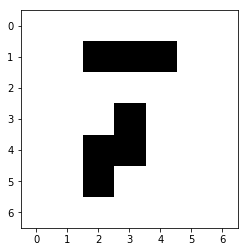

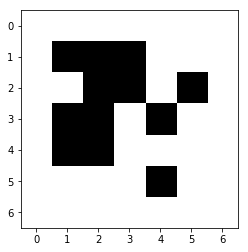

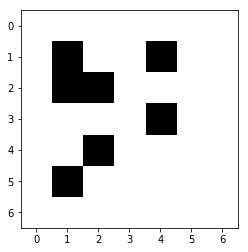

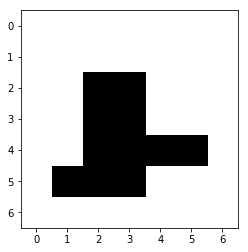

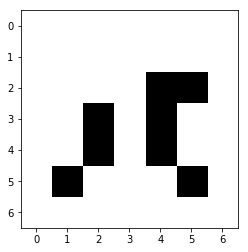

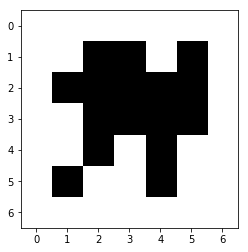

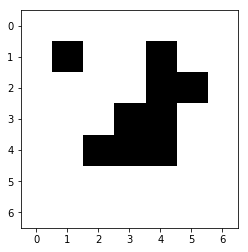

In [608]:
for pixels in pixels_array:
    plt.imshow(pixels.reshape((7,7)), cmap='gray', interpolation='none')
    plt.show()

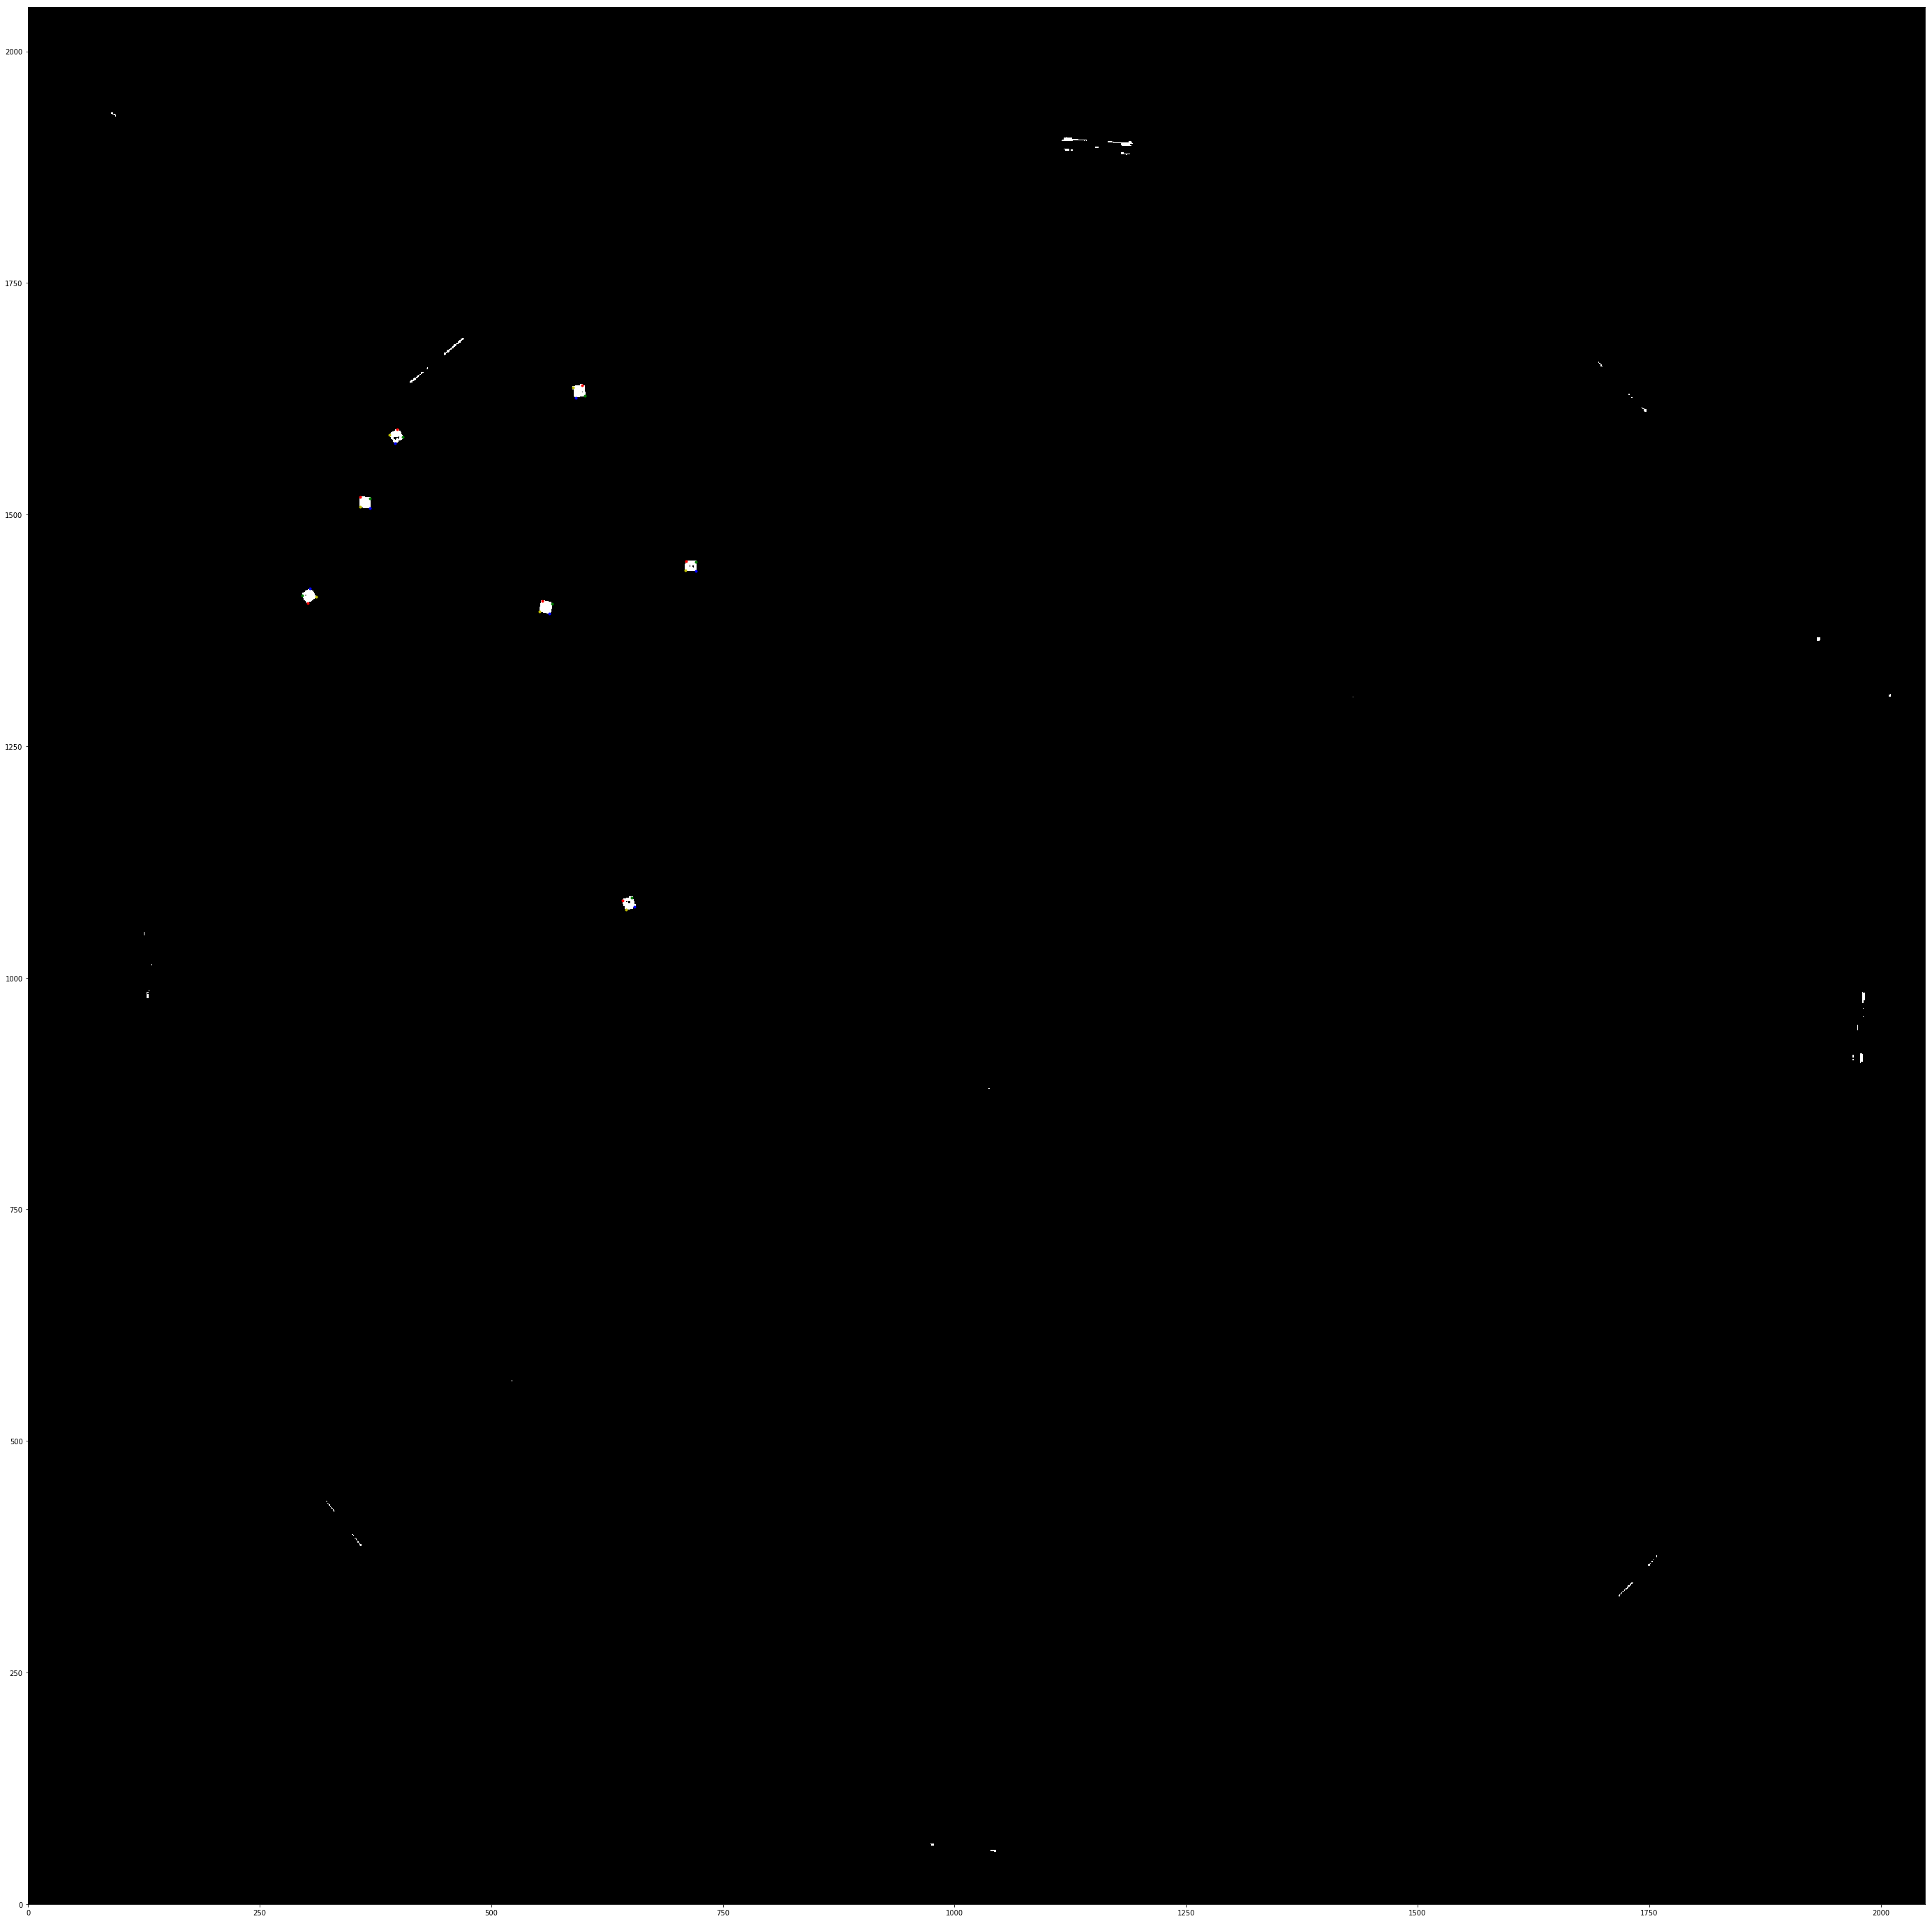

In [609]:
plt.figure(figsize=(50,50))
plt.imshow(thresh, cmap='gray', interpolation='nearest')
for points in points_array:
    plt.plot(points[0,0], points[0,1], 'r.')
    plt.plot(points[1,0], points[1,1], 'g.')
    plt.plot(points[2,0], points[2,1], 'b.')
    plt.plot(points[3,0], points[3,1], 'y.')
plt.ylim(0,2048)
plt.show()

In [198]:
points_array - test

array([[[ 0.20953369, -0.18334961],
        [-0.32891846, -0.20263672],
        [-0.4475708 ,  0.67578125],
        [ 0.43945312, -0.17822266]],

       [[ 0.22698975, -0.0592041 ],
        [-1.03515625,  0.62792969],
        [-0.215271  , -0.21166992],
        [ 0.77825928, -0.61791992]],

       [[-0.30102539, -0.40637207],
        [-0.17034912, -0.13037109],
        [-0.05212402,  0.2779541 ],
        [-0.10821533,  0.41381836]],

       [[-0.18280029, -0.63256836],
        [ 0.09710693, -0.44104004],
        [ 0.83837891,  0.69091797],
        [ 0.61785889, -0.20300293]],

       [[-0.43927002, -1.24523926],
        [-0.38082886, -0.28491211],
        [-0.24798584,  0.54150391],
        [ 0.13989258,  0.24499512]],

       [[ 0.67883301,  0.52001953],
        [-0.15481567, -0.57299805],
        [-0.85726929, -0.6640625 ],
        [ 0.44995117, -0.06030273]],

       [[ 0.34573364,  0.81237793],
        [ 0.18505859, -0.24267578],
        [-0.54901123, -0.69616699],
        [-0.9340

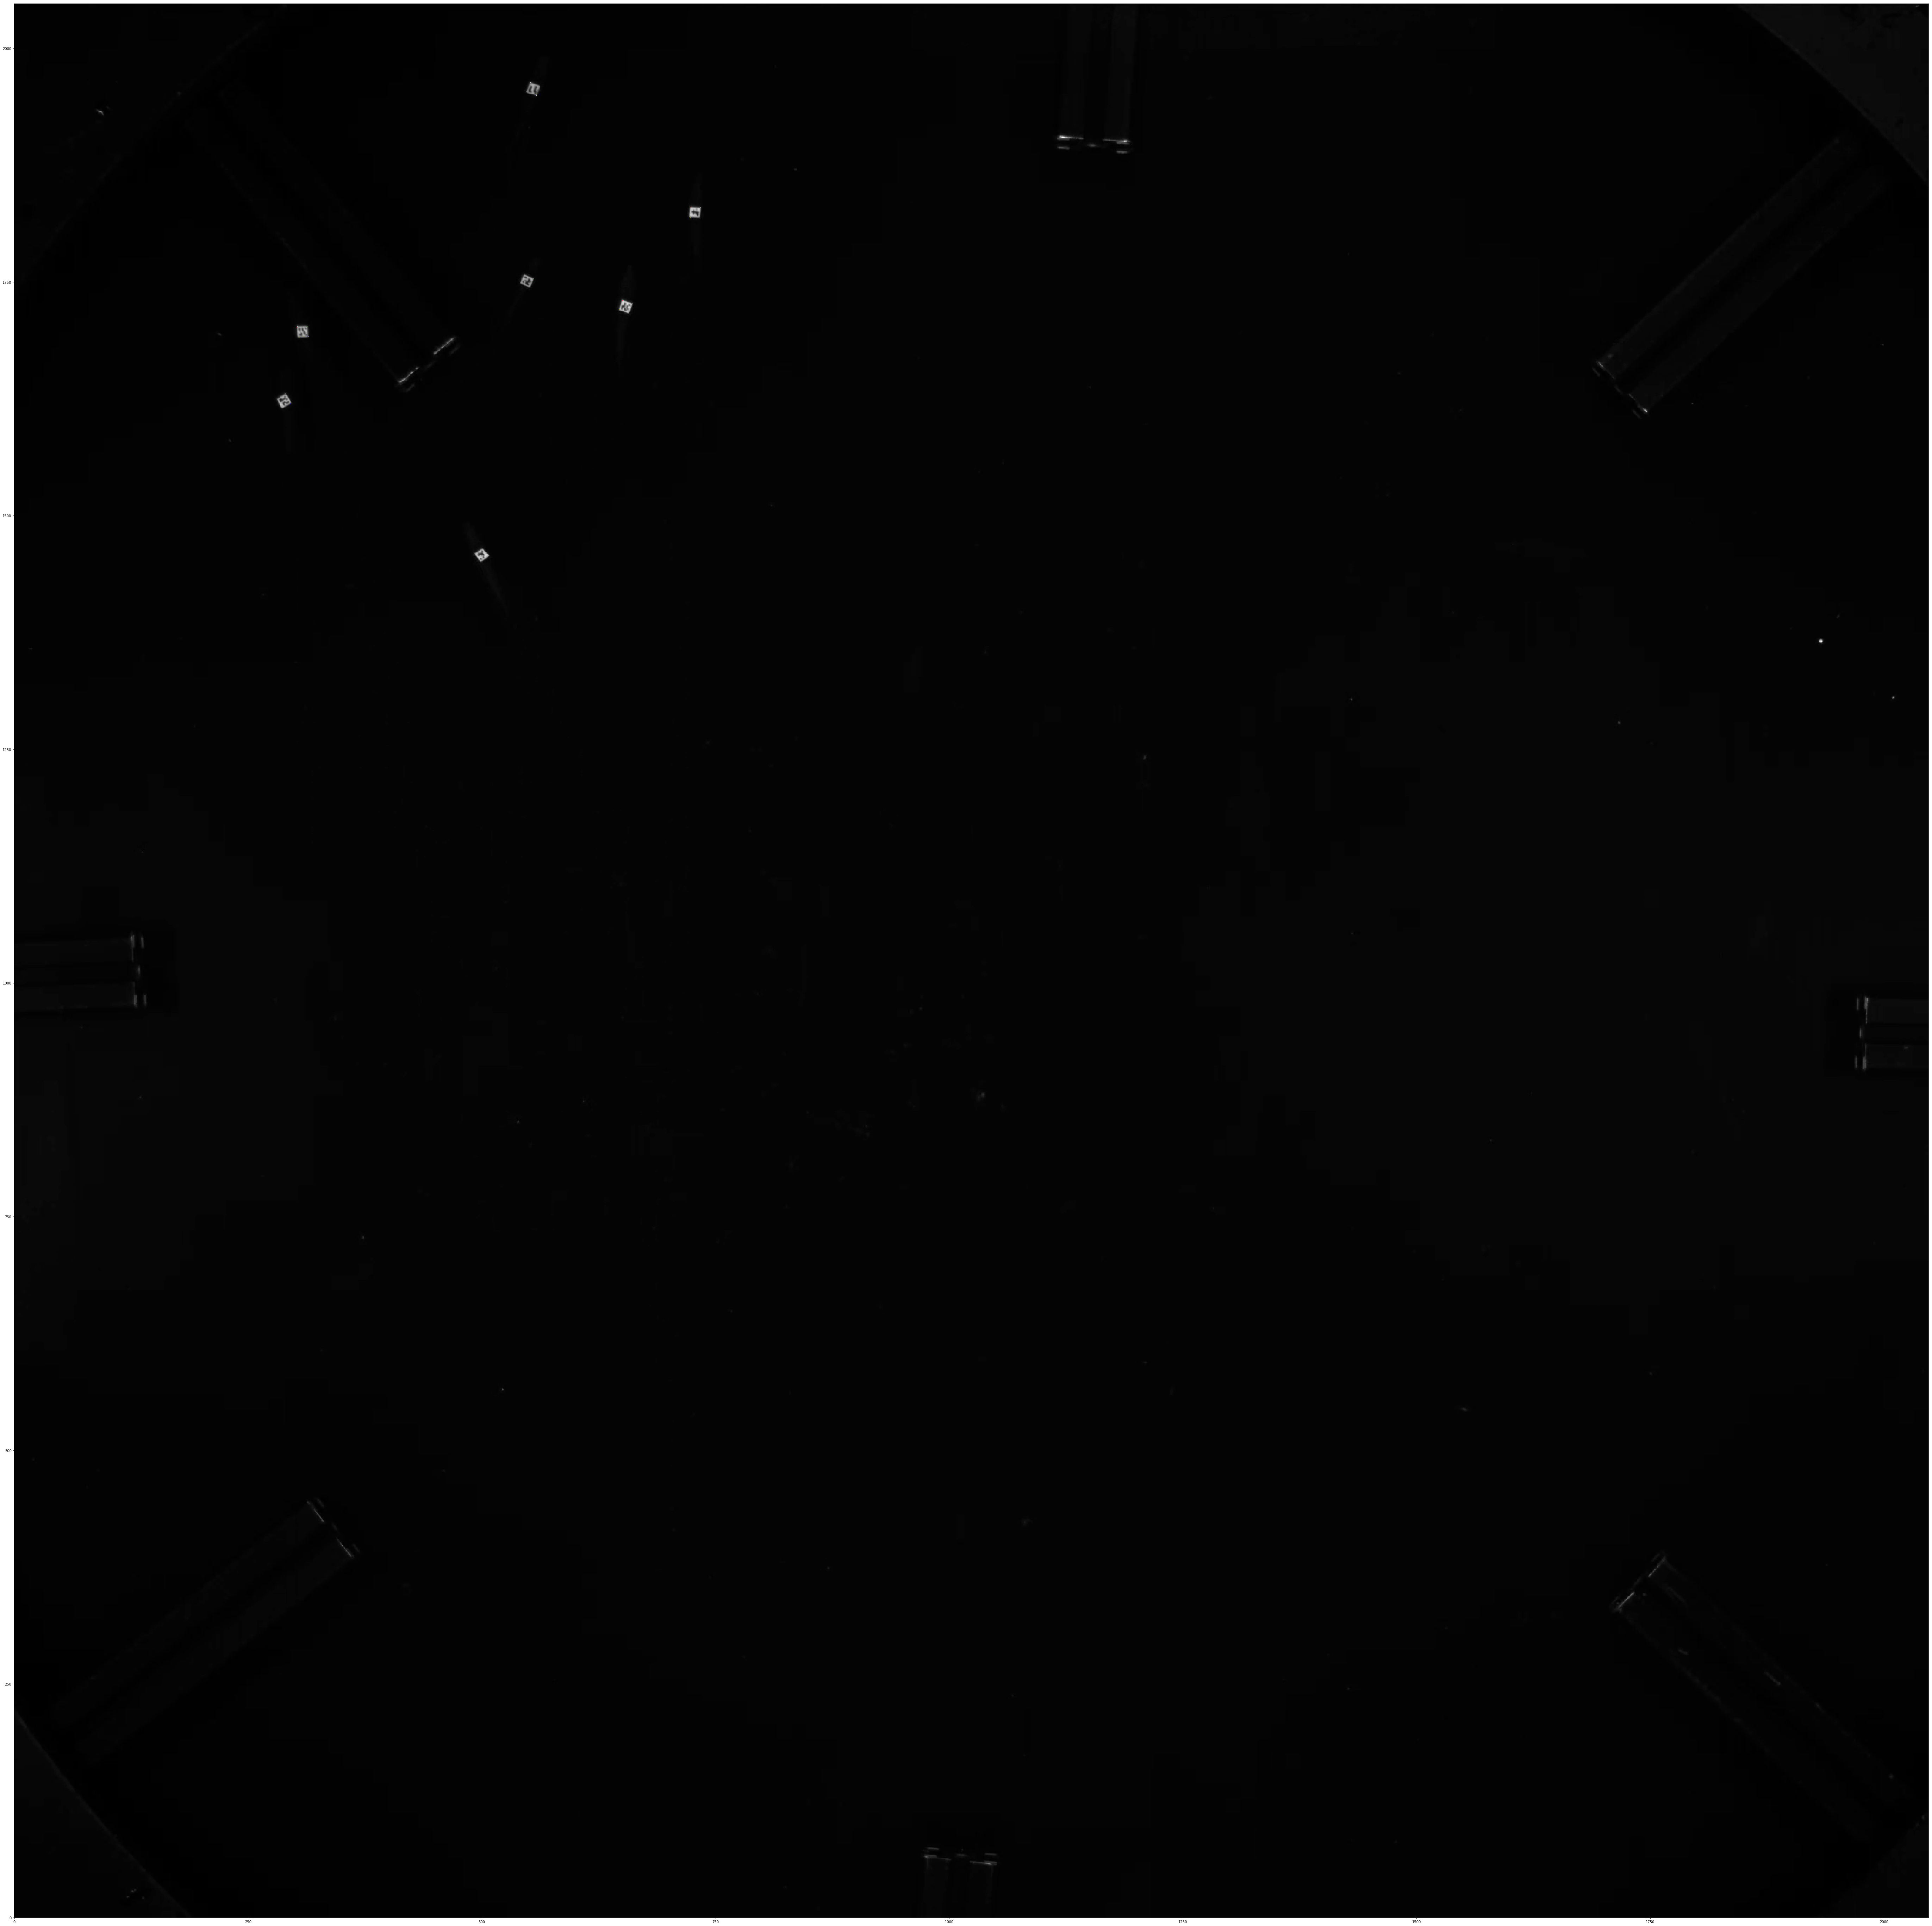

In [199]:
plt.figure(figsize=(100,100))
plt.imshow(gray, cmap='gray', interpolation='none')
for points in points_array:
    plt.plot(points[0,0], points[0,1], 'r,')
    plt.plot(points[1,0], points[1,1], 'g,')
    plt.plot(points[2,0], points[2,1], 'b,')
    plt.plot(points[3,0], points[3,1], 'y,')
for points in test:
    plt.plot(points[0,0], points[0,1], 'w,')
    plt.plot(points[1,0], points[1,1], 'w,')
    plt.plot(points[2,0], points[2,1], 'w,')
    plt.plot(points[3,0], points[3,1], 'w,')
plt.ylim(0,2048)
plt.show()

In [136]:
tracker.read_batch()

[array([[[2, 2, 2],
         [2, 2, 2],
         [1, 1, 1],
         ..., 
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[2, 2, 2],
         [2, 2, 2],
         [1, 1, 1],
         ..., 
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[2, 2, 2],
         [2, 2, 2],
         [1, 1, 1],
         ..., 
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ..., 
        [[3, 3, 3],
         [3, 3, 3],
         [3, 3, 3],
         ..., 
         [4, 4, 4],
         [4, 4, 4],
         [4, 4, 4]],
 
        [[3, 3, 3],
         [3, 3, 3],
         [3, 3, 3],
         ..., 
         [4, 4, 4],
         [4, 4, 4],
         [4, 4, 4]],
 
        [[3, 3, 3],
         [3, 3, 3],
         [3, 3, 3],
         ..., 
         [4, 4, 4],
         [4, 4, 4],
         [4, 4, 4]]], dtype=uint8), array([[[2, 2, 2],
         [2, 2, 2],
         [1, 1, 1],
         ..., 
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        

In [137]:
points_array.shape

(6, 4, 2)

In [145]:
correlations = pairwise_distances(tracker.pixels_array/255.,tracker.barcode_list, metric='cityblock')

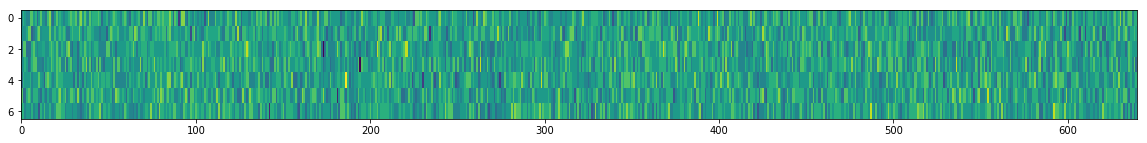

In [146]:
plt.figure(figsize=(20,2))
plt.imshow(correlations, cmap='viridis', interpolation='none', aspect='auto')
plt.show()

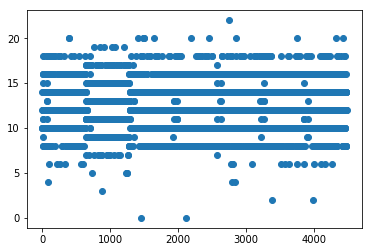

In [147]:
plt.plot(correlations.flatten(), 'o')
plt.show()

In [148]:
best_IDs.shape

NameError: name 'best_IDs' is not defined

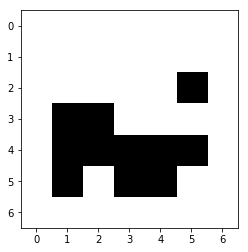

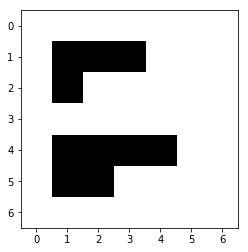

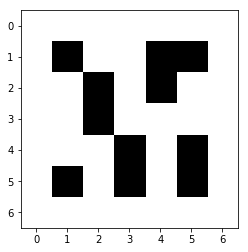

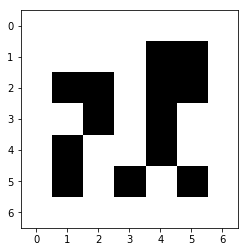

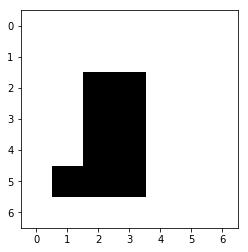

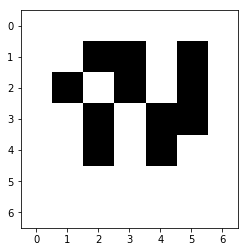

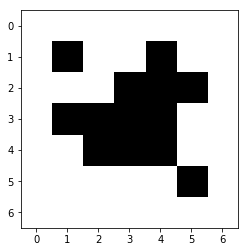

In [149]:
for pixels in tracker.pixels_array:    
    plt.imshow(pixels.reshape((7,7)), cmap='gray', interpolation='none')
    plt.show()

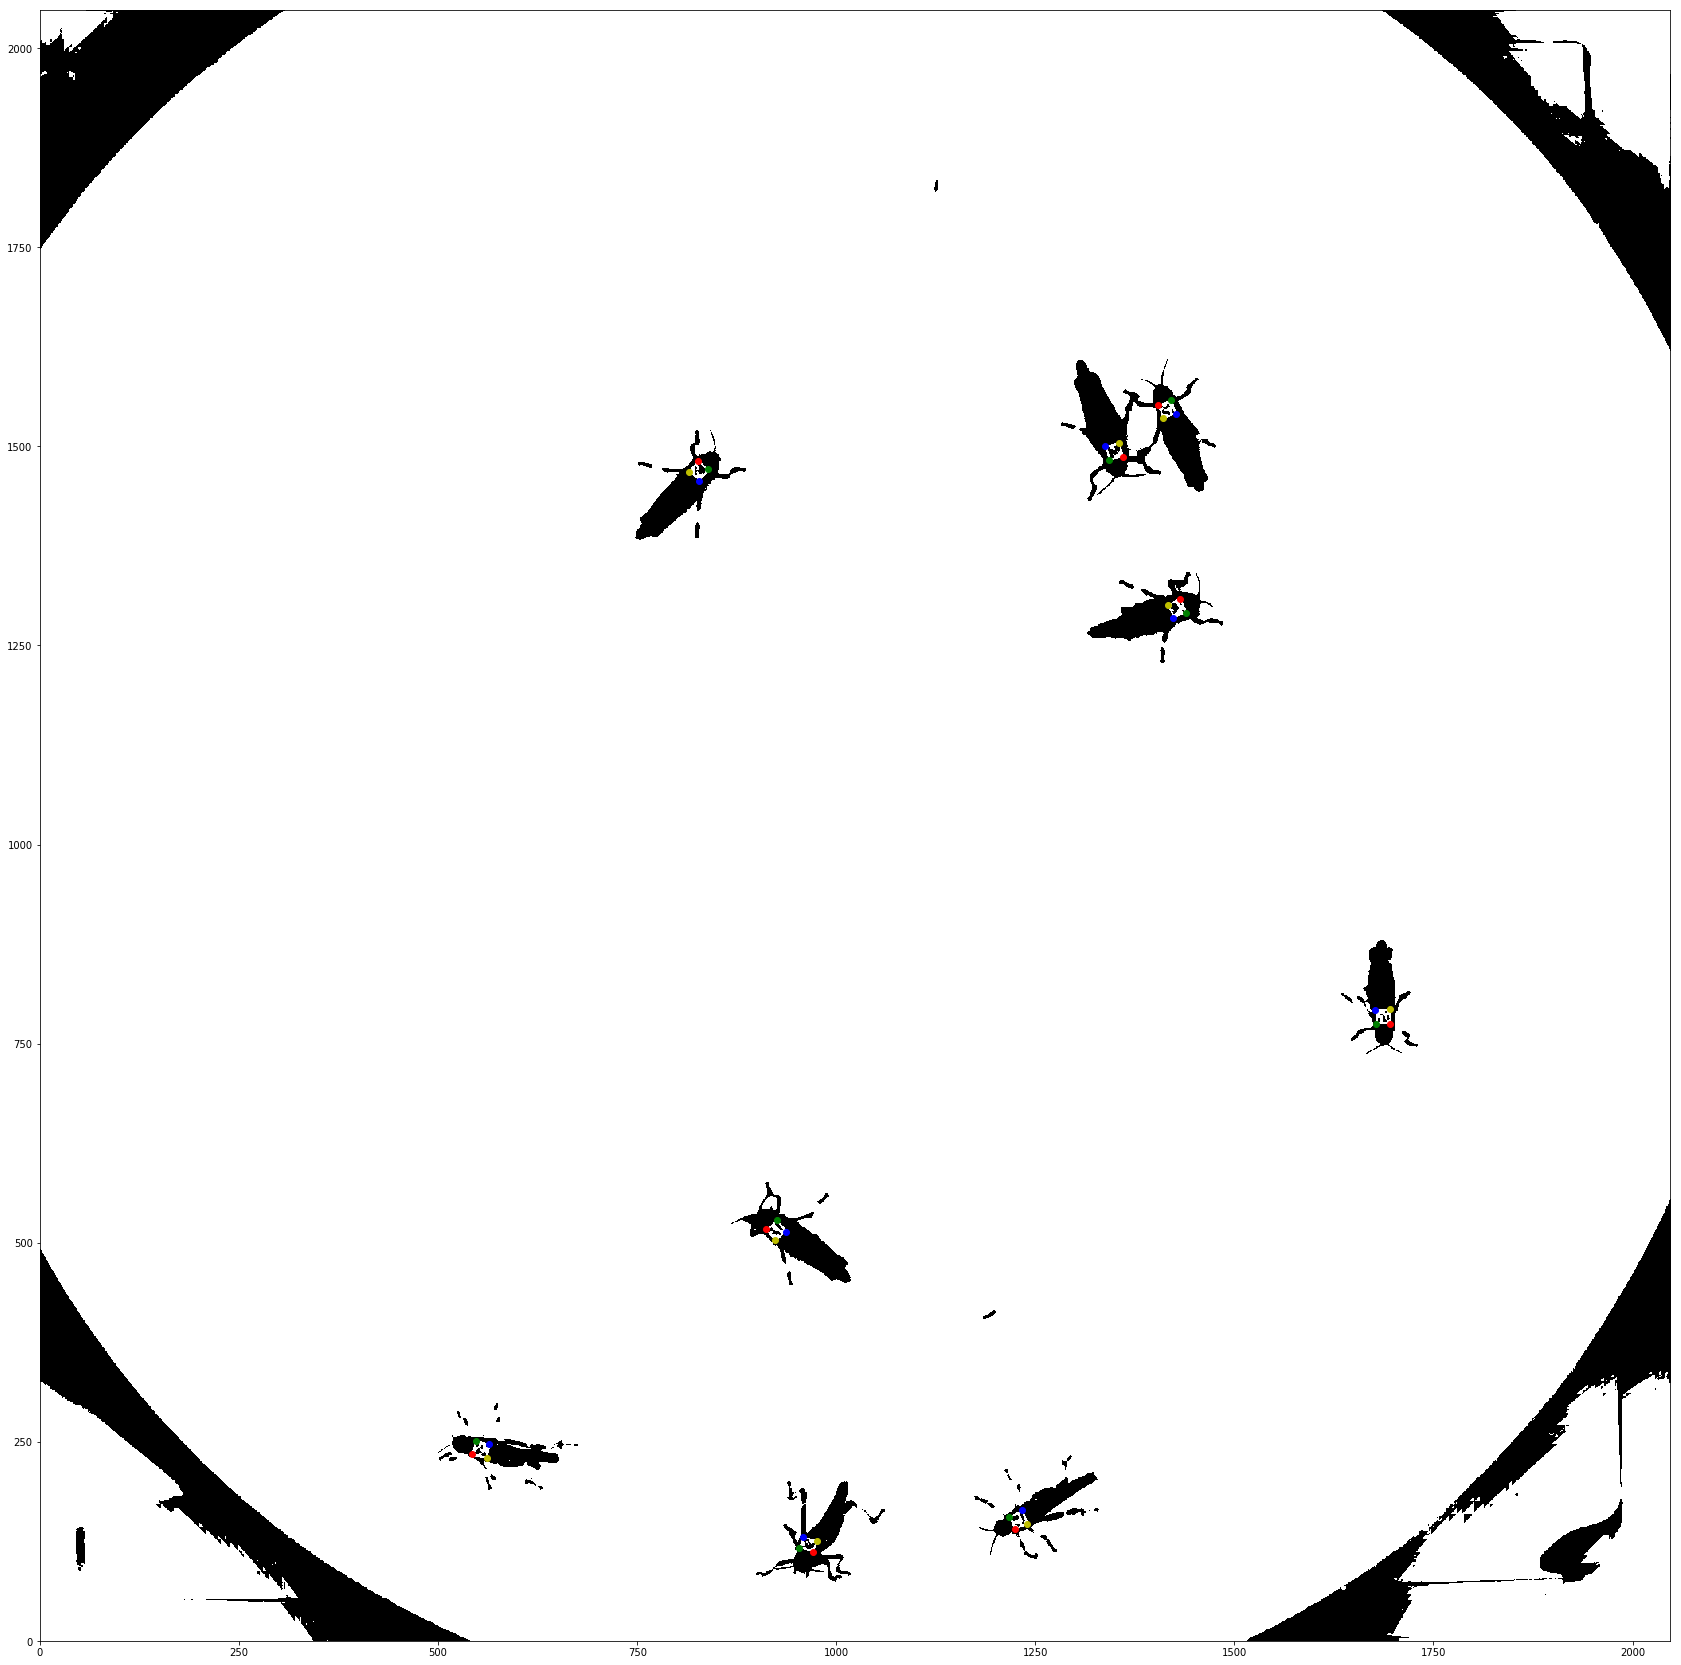

In [379]:
plt.figure(figsize=(30,30))
plt.imshow(thresh, cmap='gray', interpolation='none')
for points in points_array:
    plt.plot(points[0,0], points[0,1], 'ro')
    plt.plot(points[1,0], points[1,1], 'go')
    plt.plot(points[2,0], points[2,1], 'bo')
    plt.plot(points[3,0], points[3,1], 'yo')
#plt.xlim(0,2048)
plt.ylim(0,2048)
plt.show()